## Acesso ao Google Drive e importação dos pacotes python

In [ ]:
!pip install fancyimpute
!pip install geopandas

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.6 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=26c468a2ea860156c396d0e8757d9a2b459a55c0a5fbbdd7bdd73316b1d0f3ca
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=1c1d83d93a757d1a39c3673741d4be5d3a7e0d487bfbc705cbdc56b162e684a7
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from fancyimpute import KNN
from sklearn.ensemble import IsolationForest
import geopandas as gpd

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Leitura das tabelas

Escolhemos por trabalhar com duas tabelas, ambas cedidas pela [Rede DATALUTA](https://www.fct.unesp.br/#!/pesquisa/dataluta/).

A primeira tabela tem dados sobre os assentamentos rurais no Brasil. A segunda tabela, por sua vez, conta com dados relacionados à estrangerização de terras no Brasil.

# Tabela 1

## Definição de tipos e overview dos dados

Leitura da tabela de assentamentos removendo a primeira linha por ser um cabeçalho extra.

In [ ]:
# Tabela com dados sobre assentamentos rurais no Brasil.
assent_data = pd.read_excel("/content/drive/MyDrive/data-analysis/Assentamentos.xlsx", skiprows=[0])

In [ ]:
assent_data.head()

,REGIÃO,UF,CODIGO DO MUNICIPIO,MUNICÍPIO,CÓDIGO ASSENTAMENTO,TIPO ASSENTAMENTO,NOME ASSENTAMENTO,CONTA,ANO CRIAÇÃO,ÁREA (HECTARES),CAPACIDADE (FAMILIAS),FAMÍLIAS ASSENTADAS,FASE,TIPO ATO CRIAÇÃO,NUM ATO CR,DATA ATO CR,FORMA OBT,DATA OBT,FONTE
0,N,AM,1300904,CANUTAMA,AM0139000,FLOE,FLOE CANUTAMA,1,2009,150588.57,200,199,03,POR,0054,2009-11-16 00:00:00,Reconhecimento,2009-11-16 00:00:00,INCRA
1,N,AM,1304104,TAPAUA,AM0140000,FLOE,FLOE TAPAUA,1,2009,881704,200,81,04,POR,0055,2009-11-16 00:00:00,Reconhecimento,2009-03-27 00:00:00,INCRA
2,N,AM,1301704,HUMAITA,AM0055000,FLONA,FLONA - FLORESTA NACIONAL DE HUMAITÁ,1,2004,468790,160,108,04,POR,23,2004-07-28 00:00:00,Reconhecimento,1998-02-02 00:00:00,INCRA
3,N,AM,1303502,PAUINI,AM0072000,FLONA,FLONA - FLORESTA NACIONAL DO PURUS,1,2005,256000,340,321,04,POR,035,2005-09-26 00:00:00,Reconhecimento,1988-06-21 00:00:00,INCRA
4,N,AM,1300706,BOCA DO ACRE,AM0071000,FLONA,FLONA - FLORESTA NACIONAL MAPIÁ INAUINI,1,2005,311000,400,57,04,POR,034,2005-09-26 00:00:00,Reconhecimento,1989-08-14 00:00:00,INCRA


Renomeando as colunas. Removendo o espaço entre as palavras e substituindo por '-'.

In [ ]:
new_columns = assent_data.columns.str.replace(' ', '-', regex=True)
assent_data.columns = new_columns
assent_data.head()

,REGIÃO,UF,CODIGO-DO-MUNICIPIO,MUNICÍPIO,CÓDIGO-ASSENTAMENTO,TIPO-ASSENTAMENTO,NOME-ASSENTAMENTO,CONTA,ANO-CRIAÇÃO,ÁREA-(HECTARES),CAPACIDADE-(FAMILIAS),FAMÍLIAS-ASSENTADAS,FASE,TIPO-ATO-CRIAÇÃO,NUM-ATO-CR,DATA-ATO-CR,FORMA-OBT,DATA-OBT,FONTE
0,N,AM,1300904,CANUTAMA,AM0139000,FLOE,FLOE CANUTAMA,1,2009,150588.57,200,199,03,POR,0054,2009-11-16 00:00:00,Reconhecimento,2009-11-16 00:00:00,INCRA
1,N,AM,1304104,TAPAUA,AM0140000,FLOE,FLOE TAPAUA,1,2009,881704,200,81,04,POR,0055,2009-11-16 00:00:00,Reconhecimento,2009-03-27 00:00:00,INCRA
2,N,AM,1301704,HUMAITA,AM0055000,FLONA,FLONA - FLORESTA NACIONAL DE HUMAITÁ,1,2004,468790,160,108,04,POR,23,2004-07-28 00:00:00,Reconhecimento,1998-02-02 00:00:00,INCRA
3,N,AM,1303502,PAUINI,AM0072000,FLONA,FLONA - FLORESTA NACIONAL DO PURUS,1,2005,256000,340,321,04,POR,035,2005-09-26 00:00:00,Reconhecimento,1988-06-21 00:00:00,INCRA
4,N,AM,1300706,BOCA DO ACRE,AM0071000,FLONA,FLONA - FLORESTA NACIONAL MAPIÁ INAUINI,1,2005,311000,400,57,04,POR,034,2005-09-26 00:00:00,Reconhecimento,1989-08-14 00:00:00,INCRA


No passo seguinte, vamos analisar os tipos de cada coluna. Visualizamos que temos dados tanto do tipo categórico (object) quanto numérico (int64). Também identificamos que algumas colunas estão o com tipo de dado errado, sendo categorizadas como object, quando na verdade são dados numéricos. Por exemplo, área em hect.

In [ ]:
assent_data.dtypes

REGIÃO                   object
UF                       object
CODIGO-DO-MUNICIPIO       int64
MUNICÍPIO                object
CÓDIGO-ASSENTAMENTO      object
TIPO-ASSENTAMENTO        object
NOME-ASSENTAMENTO        object
CONTA                     int64
ANO-CRIAÇÃO               int64
ÁREA-(HECTARES)          object
CAPACIDADE-(FAMILIAS)     int64
FAMÍLIAS-ASSENTADAS      object
FASE                     object
TIPO-ATO-CRIAÇÃO         object
NUM-ATO-CR               object
DATA-ATO-CR              object
FORMA-OBT                object
DATA-OBT                 object
FONTE                    object
dtype: object

Para solucionar o problema da tipificação observado na etapa anterior, faremos a implementação de uma função de floatificação. Atráves dela iremos fazer o cast do dados para o tipo correto. Importante salientar que caso um valor não possa ser convertido para float, ele será substituido para represantação númerica de valor nulo da biblioteca numpy.

In [ ]:
def floatify(s):
  try:
    return float(s)
  except ValueError:
    return np.nan

# Colunas que observamos tipo de dado incongruente
columns = ['ÁREA-(HECTARES)', 'FAMÍLIAS-ASSENTADAS', 'FASE', 'NUM-ATO-CR']
assent_data[columns] = assent_data[columns].applymap(floatify)

Ao ter analisado a tabela por meio de um software de planilhas, observamos a presenção de valores N.I. e/ou N.I - siglas para Não Identificado. Para compreender a magnitude da presença de tais tokens, resolvemos buscar em quais colunas ele é encontrado.

In [ ]:
assent_data[assent_data.eq('N.I.' or 'N.I')].any()

REGIÃO                   False
UF                       False
CODIGO-DO-MUNICIPIO      False
MUNICÍPIO                False
CÓDIGO-ASSENTAMENTO       True
TIPO-ASSENTAMENTO         True
NOME-ASSENTAMENTO         True
CONTA                    False
ANO-CRIAÇÃO              False
ÁREA-(HECTARES)          False
CAPACIDADE-(FAMILIAS)    False
FAMÍLIAS-ASSENTADAS      False
FASE                     False
TIPO-ATO-CRIAÇÃO          True
NUM-ATO-CR               False
DATA-ATO-CR               True
FORMA-OBT                 True
DATA-OBT                  True
FONTE                    False
dtype: bool

Esses valores podem ser entendidos como valores nulos e, por isso, decidimos substituí-los pelo `np.nan`. Essa substituição será especialmente útil no tratamento de dados ausentes.

In [ ]:
def remove_ni(s):
  if s == 'N.I' or s == 'N.I.':
    return np.nan
  else:
    return s

assent_data = assent_data.applymap(remove_ni)

É possível observar com a saída da célula abaixo que não há mais os tokens N.I. e N.I

In [ ]:
assent_data[assent_data.eq('N.I.' or 'N.I')].any()

REGIÃO                   False
UF                       False
CODIGO-DO-MUNICIPIO      False
MUNICÍPIO                False
CÓDIGO-ASSENTAMENTO      False
TIPO-ASSENTAMENTO        False
NOME-ASSENTAMENTO        False
CONTA                    False
ANO-CRIAÇÃO              False
ÁREA-(HECTARES)          False
CAPACIDADE-(FAMILIAS)    False
FAMÍLIAS-ASSENTADAS      False
FASE                     False
TIPO-ATO-CRIAÇÃO         False
NUM-ATO-CR               False
DATA-ATO-CR              False
FORMA-OBT                False
DATA-OBT                 False
FONTE                    False
dtype: bool

## Tratamento de dados

### Remoção de dados irrelevantes

Para começar a etapa de processamento dos dados resolvemos analisar em mais detalhes cada coluna. Descobrimos que algumas colunas tem valores únicos (CONTA e FONTE) e outras colunas são identificadores, por isso escolhemos removê-las, uma vez que não trazem informações relevantes para nossa análise.

In [ ]:
columns = assent_data.columns
for col in columns:
  print(col, len(assent_data[col].unique()))
print('\nNúmero de instâncias: ', len(assent_data))

REGIÃO 5
UF 27
CODIGO-DO-MUNICIPIO 2153
MUNICÍPIO 2114
CÓDIGO-ASSENTAMENTO 9567
TIPO-ASSENTAMENTO 25
NOME-ASSENTAMENTO 7672
CONTA 1
ANO-CRIAÇÃO 60
ÁREA-(HECTARES) 9105
CAPACIDADE-(FAMILIAS) 661
FAMÍLIAS-ASSENTADAS 686
FASE 6
TIPO-ATO-CRIAÇÃO 7
NUM-ATO-CR 712
DATA-ATO-CR 2664
FORMA-OBT 22
DATA-OBT 2927
FONTE 2

Número de instâncias:  9583


In [ ]:
assent_data['FONTE'].unique()

array(['INCRA', nan], dtype=object)

In [ ]:
# Removendo colunas com muitos valores ou valores únicos e/ou com informação pouco relevante para análise i.e. identificadores
assent_data.drop(columns=['FONTE', 'CONTA', 'CÓDIGO-ASSENTAMENTO', 'NOME-ASSENTAMENTO', 'CODIGO-DO-MUNICIPIO'], inplace=True)

### Dados faltantes

Convertendo as colunas do tipo ```object``` para ```category```.

In [ ]:
obj_cols = assent_data.select_dtypes(include=['object']).columns
assent_data[obj_cols] = assent_data[obj_cols].astype('category')
df_categories = assent_data[obj_cols].copy()
assent_data.dtypes

REGIÃO                   category
UF                       category
MUNICÍPIO                category
TIPO-ASSENTAMENTO        category
ANO-CRIAÇÃO                 int64
ÁREA-(HECTARES)           float64
CAPACIDADE-(FAMILIAS)       int64
FAMÍLIAS-ASSENTADAS       float64
FASE                      float64
TIPO-ATO-CRIAÇÃO         category
NUM-ATO-CR                float64
DATA-ATO-CR              category
FORMA-OBT                category
DATA-OBT                 category
dtype: object

Procurando por valores nulos no dataset

In [ ]:
assent_data.isnull().sum()

REGIÃO                     0
UF                         0
MUNICÍPIO                  0
TIPO-ASSENTAMENTO         13
ANO-CRIAÇÃO                0
ÁREA-(HECTARES)            7
CAPACIDADE-(FAMILIAS)      0
FAMÍLIAS-ASSENTADAS      271
FASE                      13
TIPO-ATO-CRIAÇÃO          99
NUM-ATO-CR               126
DATA-ATO-CR               13
FORMA-OBT                 18
DATA-OBT                  47
dtype: int64

Removendo todos os registros do tipo data que possuam valor nulo.

In [ ]:
# Removendo dados faltantes com relação a datas.
assent_data.dropna(subset=['DATA-OBT'], inplace=True)
assent_data.isnull().sum()

REGIÃO                     0
UF                         0
MUNICÍPIO                  0
TIPO-ASSENTAMENTO         12
ANO-CRIAÇÃO                0
ÁREA-(HECTARES)            6
CAPACIDADE-(FAMILIAS)      0
FAMÍLIAS-ASSENTADAS      244
FASE                       0
TIPO-ATO-CRIAÇÃO          74
NUM-ATO-CR               101
DATA-ATO-CR                0
FORMA-OBT                  0
DATA-OBT                   0
dtype: int64

Substituindo as categorias de cada coluna categórica por um código gerado pelo pandas, além de criar um dicionário que mapeie cada código a sua respectiva categoria.

In [ ]:
cat_cols = assent_data.select_dtypes(include=['category']).columns
cod_cat = {}
for col in cat_cols:
  print(assent_data[col].dtypes)
  cod_cat[col] = {code: category for code, category in enumerate(assent_data[col].cat.categories)}
  assent_data[col] = assent_data[col].cat.codes

category
category
category
category
category
category
category
category


Na conversão de categorico para códigos, os registros que tinham o valor nulo receberam o código ```-1```, para poder realizar a imputação transformamos de volta os ```-1``` em ```np.nan```.

In [ ]:
# Verificando quantidade de nulos
def replace_nan_code(s):
  if s == -1:
    return np.nan
  else:
    return s

assent_data = assent_data.applymap(replace_nan_code)
assent_data.isnull().sum()

REGIÃO                     0
UF                         0
MUNICÍPIO                  0
TIPO-ASSENTAMENTO         12
ANO-CRIAÇÃO                0
ÁREA-(HECTARES)            6
CAPACIDADE-(FAMILIAS)      0
FAMÍLIAS-ASSENTADAS      244
FASE                       0
TIPO-ATO-CRIAÇÃO          74
NUM-ATO-CR               101
DATA-ATO-CR                0
FORMA-OBT                  0
DATA-OBT                   0
dtype: int64

Para fazer realizar a imputação dos dados faltantes, escolheremos 1 dentre 3 técnicas:
- Imputação pela média
- Imputação pela mediana
- Imputação atráves do knn

A escolha é feita individualmente para cada coluna, e o método escolhido é aquele que menos altera as métricas de média.
Para as colunas categóricas foi escolhido o método de imputação pela mediana, para evitar a presença de valores fracionados. Esses valores impediriam a transformação para a respectiva categoria nos passos seguintes.

In [ ]:
imputer = KNN(k=5, verbose=False)

def escolha_imputação(df, col_name, knn, metodos=[]):
  print(col_name + ' sem imputação:')
  print(f'{col_name} median', df[col_name].median())
  print(f'{col_name} mean', df[col_name].mean(), '\n')
  for i in metodos:
    if i == 'median':
      res = df[col_name].fillna(df[col_name].median()).copy()
    elif i == 'mean':
      res = df[col_name].fillna(df[col_name].mean()).copy()
    elif i == 'knn':
      res = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)[col_name]

    print(i + ':')
    print(f'{col_name} median', res.median())
    print(f'{col_name} mean', res.mean(), '\n')

cols_imp = ['TIPO-ASSENTAMENTO', 'ÁREA-(HECTARES)', 'FAMÍLIAS-ASSENTADAS', 'TIPO-ATO-CRIAÇÃO', 'NUM-ATO-CR']
metodos = ['median', 'mean', 'knn']

for col in cols_imp:
  escolha_imputação(assent_data.copy(), col, imputer, metodos)

TIPO-ASSENTAMENTO sem imputação:
TIPO-ASSENTAMENTO median 3.0
TIPO-ASSENTAMENTO mean 5.45905081898362 

median:
TIPO-ASSENTAMENTO median 3.0
TIPO-ASSENTAMENTO mean 5.455956375838926 

mean:
TIPO-ASSENTAMENTO median 3.0
TIPO-ASSENTAMENTO mean 5.45905081898362 

knn:
TIPO-ASSENTAMENTO median 3.0
TIPO-ASSENTAMENTO mean 5.460171698192948 

ÁREA-(HECTARES) sem imputação:
ÁREA-(HECTARES) median 1367.7
ÁREA-(HECTARES) mean 9349.030634081846 

median:
ÁREA-(HECTARES) median 1367.7
ÁREA-(HECTARES) mean 9344.008823699665 

mean:
ÁREA-(HECTARES) median 1367.8667999999998
ÁREA-(HECTARES) mean 9349.030634081848 

knn:
ÁREA-(HECTARES) median 1367.5169
ÁREA-(HECTARES) mean 9343.882457062578 

FAMÍLIAS-ASSENTADAS sem imputação:
FAMÍLIAS-ASSENTADAS median 47.0
FAMÍLIAS-ASSENTADAS mean 105.60083943176926 

median:
FAMÍLIAS-ASSENTADAS median 47.0
FAMÍLIAS-ASSENTADAS mean 104.10140520134229 

mean:
FAMÍLIAS-ASSENTADAS median 49.0
FAMÍLIAS-ASSENTADAS mean 105.60083943176926 

knn:
FAMÍLIAS-ASSENTADAS media

Como observado acima, para o número de hectares a imputação por média foi a que resultou em menos variação. Por sua vez, knn variou menos para famílias assentadas e número ato.

Na célula abaixo realizamos a imputação das colunas de acordo com o método escolhido. Depois fazemos a checagem se todos os valores foram imputados.

In [ ]:
def imputação(df, col_name, metodo, knn=None):
    if metodo == 'median':
        return df[col_name].fillna(df[col_name].median())
    elif metodo == 'mean':
        return df[col_name].fillna(df[col_name].mean())
    elif metodo == 'knn':
        return pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)[col_name]

# Para dados categóricos estamos utilizando mediana
imp_list = [('TIPO-ASSENTAMENTO', 'median'), ('ÁREA-(HECTARES)', 'mean'), ('FAMÍLIAS-ASSENTADAS', 'knn'), ('NUM-ATO-CR','median'), ('TIPO-ATO-CRIAÇÃO', 'median')]

assent_data_nan = assent_data.copy()

for col in imp_list:
  assent_data[col[0]] = imputação(assent_data_nan, col[0], col[1], imputer)

assent_data.isnull().sum()

REGIÃO                   0
UF                       0
MUNICÍPIO                0
TIPO-ASSENTAMENTO        0
ANO-CRIAÇÃO              0
ÁREA-(HECTARES)          0
CAPACIDADE-(FAMILIAS)    0
FAMÍLIAS-ASSENTADAS      0
FASE                     0
TIPO-ATO-CRIAÇÃO         0
NUM-ATO-CR               0
DATA-ATO-CR              0
FORMA-OBT                0
DATA-OBT                 0
dtype: int64

Por fim plotamos a matriz de correlação de spearman para o dataset pós-imputação.

<Axes: >

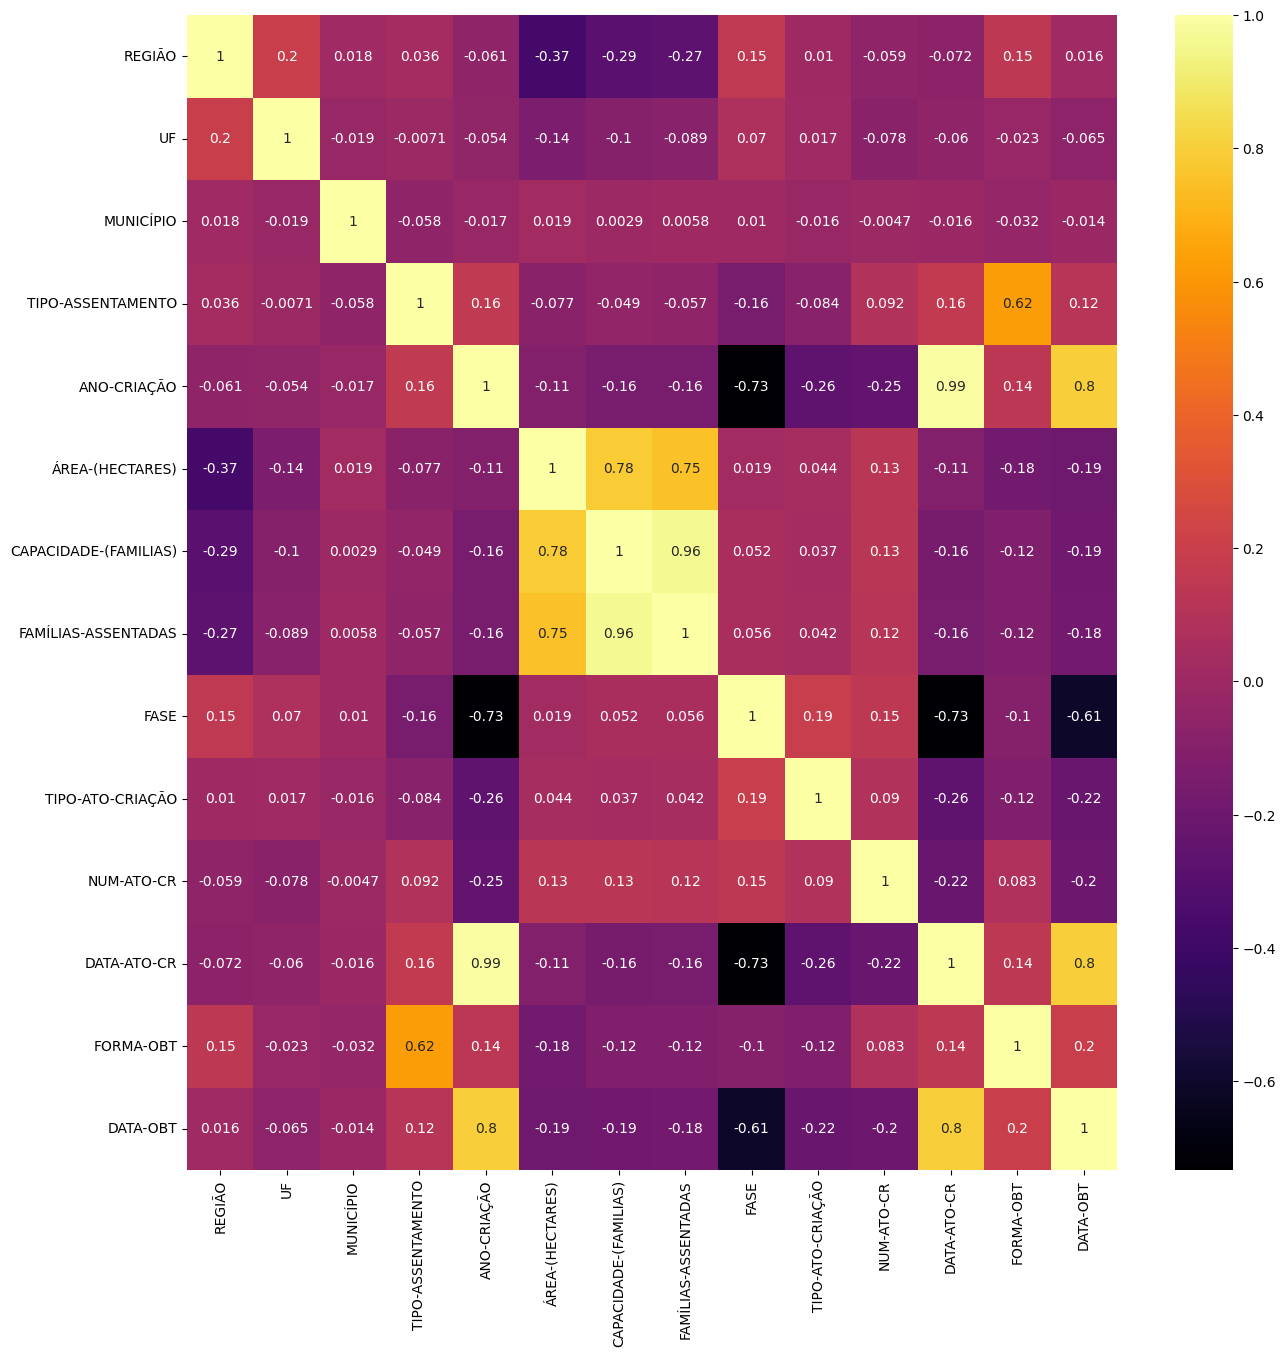

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(assent_data.corr('spearman'), cmap='inferno', annot=True)

A partir das correlações presentes na matriz, podemos destacar alguns pontos:

* **Correlação Positiva**:
  * CAPACIDADE-(FAMILIAS) e FAMILIAS-ASSENTADAS: Correlação de 0.96, indicando que quanto maior a capacidade do assentamento, maior o número de famílias assentadas. Isso é esperado, pois a capacidade deve estar diretamente relacionada ao número de famílias que podem ser acomodadas.
  * ÁREA-(HECTARES) tem uma correlação forte positiva com CAPACIDADE-(FAMILIAS) (0.78) e FAMILIAS-ASSENTADAS (0.75). Isto sugere que áreas maiores tendem a ter uma maior capacidade e mais famílias assentadas.
  * DATA-ATO-CR e DATA-OBT: Correlação de 0.80, o que pode indicar que a data de obtenção e a data do ato de criação dos assentamentos são muito próximas.

* **Correlação Negativa**:
  * ANO-CRIACAO e FASE: Correlação de -0.73, indicando que assentamos mais antigos estão, no geral, em uma fase mais avançada.

### Instâncias duplicadas

Fazemos uma chegagem se há registros duplicados na base. Foi identificado apenas um registro duplicado e vamos eliminá-lo usando o seguinte comando ```assent_data.drop_duplicates(inplace=True)```.

In [ ]:
assent_data.duplicated().sum()

1

In [ ]:
assent_data.drop_duplicates(inplace=True)

### Outliers

O passo seguinte do processamento dos dados será a identificação e eliminação de _outliers_. Para isso faremos 3 tipos de análise:
- Univariada
- Bivariada
- Multivariada

#### Univariada

Para a análise univariada escolhemos a coluna ```ÁREA-(HECTARES)```. Para ter uma melhor visualização da distribuição dessa coluna, decidimos fazer o boxplot dela.

<Axes: >

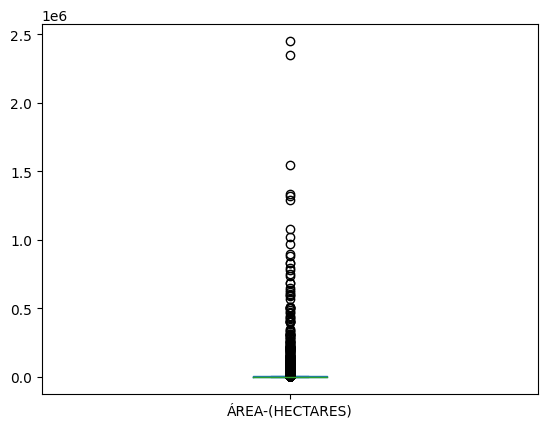

In [ ]:
assent_data['ÁREA-(HECTARES)'].plot.box()

Logo percebemos a presença de um número significativo de dados fora do padrão. Por exemplo, assentamentos com mais de 2 milhões de hectares enquanto que a maioria dos dados se concentra em 100 mil hectares.

Para um melhor entendimento de como a área se comporta, podemos plotar seu histograma.

<Axes: >

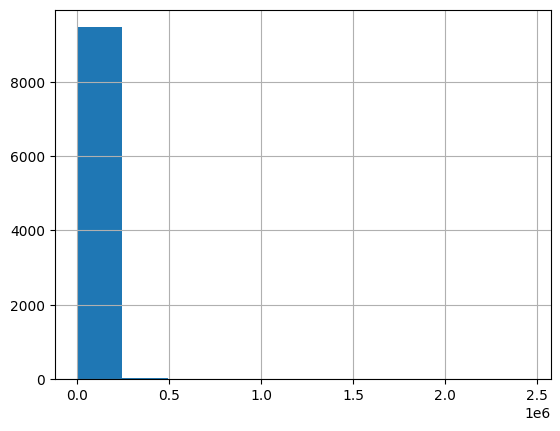

In [ ]:
assent_data['ÁREA-(HECTARES)'].hist()

Adicionamente também plotamos o histograma dessa coluna e percebemos que ela segue uma distribuição exponencial. Ele mostra uma distribuição muito concentada nos valores baixos de área.

Eliminando registros com área 0, pois se configuram como dados errôneos.

In [ ]:
assent_data_1 = assent_data[assent_data['ÁREA-(HECTARES)']!=0].copy()

Aplicando uma operação logarítmica para parametrizar a coluna em uma distribuição mais próxima da normal.

<Axes: >

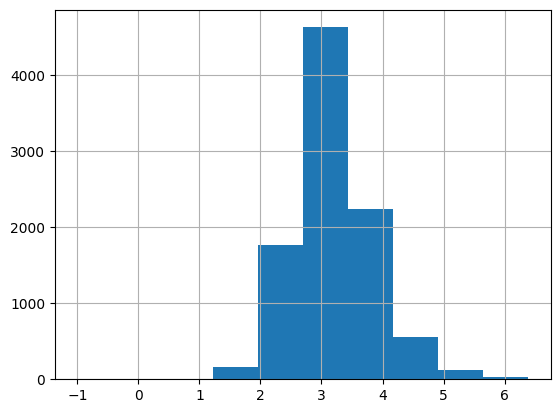

In [ ]:
assent_data_1['log_area'] = np.log10(assent_data_1['ÁREA-(HECTARES)'])
assent_data_1['log_area'].hist()

Após a transformação logarítimica os dados se centralizaram mais em torno de 2 e 4 no eixo x, indicando um distribuição mais uniforme e menos dispersa.

Podemos proseguir com a remoção de _outliers_. Utilizaremos o método de Tukey.

In [ ]:
q1 = assent_data_1['log_area'].quantile(q=0.25)
q3 = assent_data_1['log_area'].quantile(q=0.75)
iqr = q3 - q1

assent_data_tukey = assent_data_1[(assent_data_1['log_area'] > (q1-1.5*iqr)) & (assent_data_1['log_area'] < (q3+1.5*iqr))].copy()

Plotamos também o boxplot pós-remoção para observar o resultado da técnica

9279 9534


<Axes: >

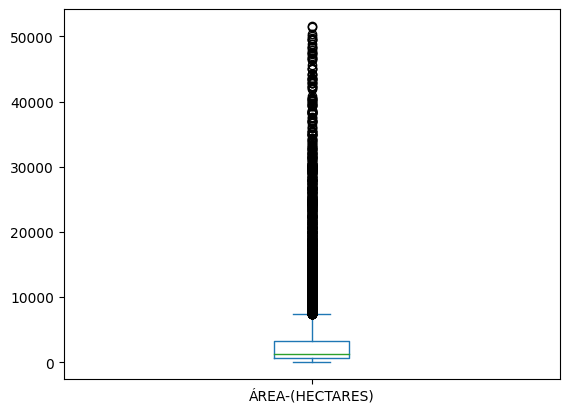

In [ ]:
print(len(assent_data_tukey), len(assent_data_1))
assent_data_tukey['ÁREA-(HECTARES)'].plot.box()

A aplicação do método de Tukey tornou a distribuição dos valores mais simétricos e que a escala foi reduzida, indicando que valores mais extremos foram removidos. No entanto, mesmo assim, o boxplot ainda mostra uma concentração significativa de outliers.

#### Bivariado

Em seguida fizemos uma análise bivariada utilizando a relação entre ```CAPACIDADE-(FAMILIAS) X ÁREA-(HECTARES)```. Para ajudar na análise utilizamos o scatter plot.

<Axes: xlabel='ÁREA-(HECTARES)', ylabel='CAPACIDADE-(FAMILIAS)'>

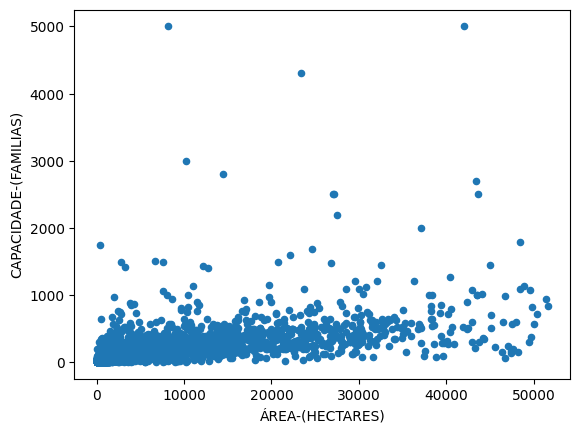

In [ ]:
assent_data_tukey.plot.scatter(x='ÁREA-(HECTARES)',y='CAPACIDADE-(FAMILIAS)')

A maioria dos pontos está concentrada na partire inferiror estudar do gráfico, indicando que a maior parcela dos assentamentos tem tanto áreas pequenas quanto uma capacidade de famílias relativamente baixa.

A distribuição dos pontos é bastante dispersa à medida que aumentamos a área em hectares. Isso sugere que, embora existam assentamentos com grandes área, eles não necessariamente têm uma capacidade proporcionalmente alta de família. O plot nos faz perceber uma relação linear muito fraca entra as duas variáveis.

Além disso, existem vários outliers visíveis no gráfico. Em particular, há um dado com uma capacidade de famílias muito elevada (5000) para uma área em hectares (10000) relativamente pequena.

Para realizar a remoção desses _outliers_ criamos uma coluna com a o valor da divisão entre a capacidade pela área. Para ter uma compreensão ainda mais fundamentada dessa relação utilizamos 2 gráficos, um histograma e um boxplot.

Atráves dele podemos observa que essa relação respeita uma distribuição exponencial e que há valores bem distoantes do padrão.

<Axes: >

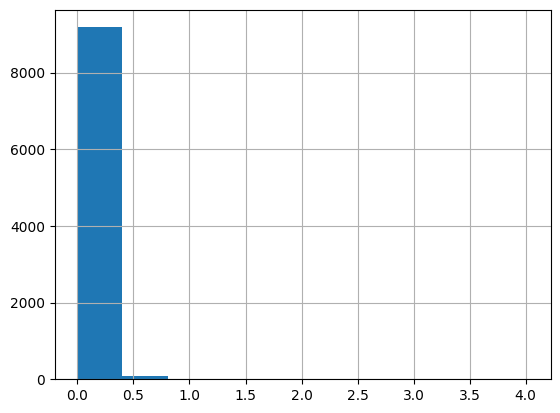

In [ ]:
assent_data_tukey['cap_fam_por_area'] = assent_data_tukey['CAPACIDADE-(FAMILIAS)'] / assent_data_tukey['ÁREA-(HECTARES)']
assent_data_tukey['cap_fam_por_area'].hist()

Podemos observar uma distruibuição altamente assimétrica e que a maioria dos assentamentos estm uma capacidade relativamente baixa em relação à area.

<Axes: >

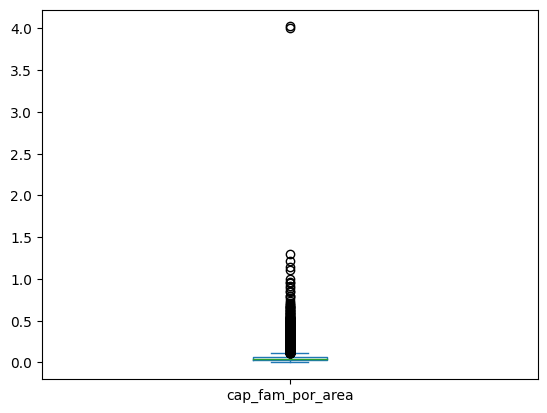

In [ ]:
assent_data_tukey['cap_fam_por_area'].plot.box()

O boxplot reforça que a maioria dos dados está concentrada em uma estreita faixa próxima ao valor 0. Além disso, há um número considerável de outliers.

Aplicando uma operação logarítmica para parametrizar a coluna em uma distribuição mais próxima da normal.

<Axes: >

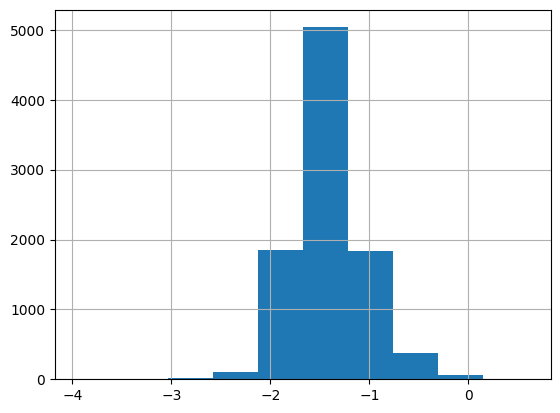

In [ ]:
assent_data_tukey['log_cap_fam_por_area'] = np.log10(assent_data_tukey['cap_fam_por_area'])
assent_data_tukey['log_cap_fam_por_area'].hist()

A transformação logarítimica foi eficaz em reduzir a assimetria observada no histograma anterior. O pico da distribuição está agora mais centralizado, e a cauda longa para a direita foi reduzida. Os valores agora estão se concentrando entre aproximadamente -2,5 e -0,5 no eixo x.

Para remover esses _outliers_ utilizamos o método do z-score robusto com o limiar sendo 3.5

9279 9145


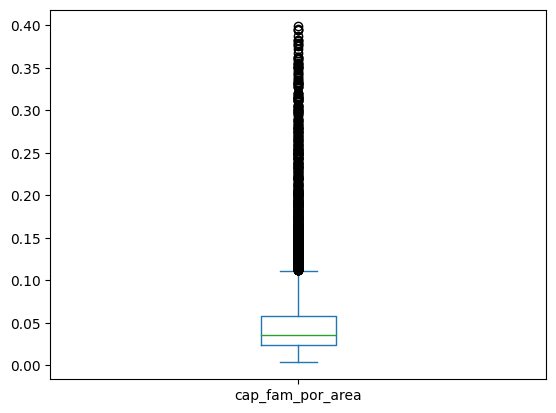

In [ ]:
mad = abs(assent_data_tukey['log_cap_fam_por_area'] - assent_data_tukey['log_cap_fam_por_area'].median()).median()*(1/0.6745)

assent_data_mad = assent_data_tukey[abs(assent_data_tukey['log_cap_fam_por_area']-assent_data_tukey['log_cap_fam_por_area'].median())/mad < 3.5].copy()

assent_data_mad['cap_fam_por_area'].plot.box()
print(len(assent_data_tukey), len(assent_data_mad))

Embora ainda existam outliers, a extensão dos outliers foi reduzida em comparação ao boxplot original. O método se mostrou eficaz em remover outliers mais extremos, auxiliando na normalização dos dados.

#### Multivariado

Por fim, chegamos na última técnica de remoção de _outliers_. Nesta etapa optamos por utilizar o _Isolation Forest_. Utilizamos novamente o boxplot para entender o efeito que este algoritmo teve na coluna utilizada na análise bivariada, é possível ver que houve uma redução do range dos valores, indicando que o método foi bem sucedido, no entanto, ainda há índicios de que valores errôneos.

8113 9145


<Axes: >

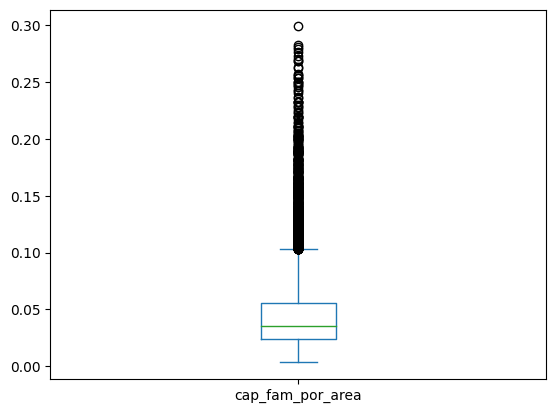

In [ ]:
assent_data_mad['outlier'] = IsolationForest(random_state=0).fit_predict(assent_data_mad)
assent_data_wout_out = assent_data_mad[assent_data_mad['outlier']==1].copy()
print(len(assent_data_wout_out), len(assent_data_mad))
assent_data_wout_out['cap_fam_por_area'].plot.box()

### Normalização

Como visto na última da remoção de _outliers_ ainda há indícios da presença de valores distoantes, por conta disso, optamos por utilizar a normalização pela mediana que mais robusta há dados com _outliers_. Importante salientar que so realizamos a normalização dos dados que são originalmente numéricos e que antes de realizar a normalização convertemos os códigos de volta em categorias.

In [ ]:
assent_data_back_cat = assent_data_wout_out.drop(columns=['log_area', 'cap_fam_por_area', 'log_cap_fam_por_area', 'outlier']).copy()
for col in list(cod_cat.keys()):
  print(col)
  categories = cod_cat[col]
  assent_data_back_cat[col] = assent_data_back_cat[col].apply(lambda x: categories[x])

assent_data_back_cat.dtypes

REGIÃO
UF
MUNICÍPIO
TIPO-ASSENTAMENTO
TIPO-ATO-CRIAÇÃO
DATA-ATO-CR
FORMA-OBT
DATA-OBT


REGIÃO                    object
UF                        object
MUNICÍPIO                 object
TIPO-ASSENTAMENTO         object
ANO-CRIAÇÃO                int64
ÁREA-(HECTARES)          float64
CAPACIDADE-(FAMILIAS)      int64
FAMÍLIAS-ASSENTADAS      float64
FASE                     float64
TIPO-ATO-CRIAÇÃO          object
NUM-ATO-CR               float64
DATA-ATO-CR               object
FORMA-OBT                 object
DATA-OBT                  object
dtype: object

Visualizando a conversão dos dados categóricos

In [ ]:
assent_data_back_cat.head()

,REGIÃO,UF,MUNICÍPIO,TIPO-ASSENTAMENTO,ANO-CRIAÇÃO,ÁREA-(HECTARES),CAPACIDADE-(FAMILIAS),FAMÍLIAS-ASSENTADAS,FASE,TIPO-ATO-CRIAÇÃO,NUM-ATO-CR,DATA-ATO-CR,FORMA-OBT,DATA-OBT
11,NE,SE,SANTO AMARO DAS BROTAS,PA,2006,312.1541,24,24.000000,3.0,POR,89.0,2006-02-15 00:00:00,Desapropriação,2005-01-13 00:00:00
12,SE,SP,IEPE,PA,2016,493.6869,52,36.955555,3.0,POR,32.0,2016-09-21 00:00:00,Desapropriação,2016-09-21 00:00:00
13,SE,MG,BURITIZEIRO,PA,2007,5299.0530,70,66.000000,4.0,POR,50.0,2007-05-16 00:00:00,Desapropriação,2006-11-29 00:00:00
14,NE,PI,MANOEL EMIDIO,PA,1997,4871.4969,77,30.000000,6.0,POR,31.0,1997-03-19 00:00:00,Compra e Venda,1994-03-20 00:00:00
15,SE,MG,TUMIRITINGA,PA,2010,572.0768,15,15.000000,3.0,POR,21.0,2010-08-20 00:00:00,Desapropriação,1999-09-09 00:00:00


Realizando a normalização

In [ ]:
scaler = RobustScaler()
scaled_assent_data = assent_data_back_cat.copy()

numeric_cols = scaled_assent_data.select_dtypes(include=[np.number]).columns
scaled_assent_data[numeric_cols] = scaler.fit_transform(scaled_assent_data[numeric_cols])
scaled_assent_data.head()

,REGIÃO,UF,MUNICÍPIO,TIPO-ASSENTAMENTO,ANO-CRIAÇÃO,ÁREA-(HECTARES),CAPACIDADE-(FAMILIAS),FAMÍLIAS-ASSENTADAS,FASE,TIPO-ATO-CRIAÇÃO,NUM-ATO-CR,DATA-ATO-CR,FORMA-OBT,DATA-OBT
11,NE,SE,SANTO AMARO DAS BROTAS,PA,0.625,-0.438109,-0.380952,-0.345455,-0.5,POR,0.833333,2006-02-15 00:00:00,Desapropriação,2005-01-13 00:00:00
12,SE,SP,IEPE,PA,1.875,-0.355239,0.063492,-0.109899,-0.5,POR,-0.222222,2016-09-21 00:00:00,Desapropriação,2016-09-21 00:00:00
13,SE,MG,BURITIZEIRO,PA,0.750,1.838433,0.349206,0.418182,0.0,POR,0.111111,2007-05-16 00:00:00,Desapropriação,2006-11-29 00:00:00
14,NE,PI,MANOEL EMIDIO,PA,-0.500,1.643251,0.460317,-0.236364,1.0,POR,-0.240741,1997-03-19 00:00:00,Compra e Venda,1994-03-20 00:00:00
15,SE,MG,TUMIRITINGA,PA,1.125,-0.319453,-0.523810,-0.509091,-0.5,POR,-0.425926,2010-08-20 00:00:00,Desapropriação,1999-09-09 00:00:00


### Discretização

Decidimos aplicar um discretização das datas, para isso utilizamos o ano e quebramos em 10 intervalos iguais de anos.

In [ ]:
scaled_assent_data['Timestamp-DATA-ATO-CR'] = pd.to_datetime(scaled_assent_data['DATA-ATO-CR']).apply(lambda x: x.year)
scaled_assent_data['Timestamp-DATA-OBT'] = pd.to_datetime(scaled_assent_data['DATA-OBT']).apply(lambda x: x.year)

In [ ]:
scaled_assent_data['BIN-DATA-ATO-CR'] = pd.cut(scaled_assent_data['Timestamp-DATA-ATO-CR'], 10)
scaled_assent_data['BIN-DATA-OBT'] = pd.cut(scaled_assent_data['Timestamp-DATA-OBT'], 10)
scaled_assent_data.head()

,REGIÃO,UF,MUNICÍPIO,TIPO-ASSENTAMENTO,ANO-CRIAÇÃO,ÁREA-(HECTARES),CAPACIDADE-(FAMILIAS),FAMÍLIAS-ASSENTADAS,FASE,TIPO-ATO-CRIAÇÃO,NUM-ATO-CR,DATA-ATO-CR,FORMA-OBT,DATA-OBT,Timestamp-DATA-ATO-CR,Timestamp-DATA-OBT,BIN-DATA-ATO-CR,BIN-DATA-OBT
11,NE,SE,SANTO AMARO DAS BROTAS,PA,0.625,-0.438109,-0.380952,-0.345455,-0.5,POR,0.833333,2006-02-15 00:00:00,Desapropriação,2005-01-13 00:00:00,2006,2005,"(2003.0, 2006.8]","(1995.2, 2007.1]"
12,SE,SP,IEPE,PA,1.875,-0.355239,0.063492,-0.109899,-0.5,POR,-0.222222,2016-09-21 00:00:00,Desapropriação,2016-09-21 00:00:00,2016,2016,"(2014.4, 2018.2]","(2007.1, 2019.0]"
13,SE,MG,BURITIZEIRO,PA,0.750,1.838433,0.349206,0.418182,0.0,POR,0.111111,2007-05-16 00:00:00,Desapropriação,2006-11-29 00:00:00,2007,2006,"(2006.8, 2010.6]","(1995.2, 2007.1]"
14,NE,PI,MANOEL EMIDIO,PA,-0.500,1.643251,0.460317,-0.236364,1.0,POR,-0.240741,1997-03-19 00:00:00,Compra e Venda,1994-03-20 00:00:00,1997,1994,"(1995.4, 1999.2]","(1983.3, 1995.2]"
15,SE,MG,TUMIRITINGA,PA,1.125,-0.319453,-0.523810,-0.509091,-0.5,POR,-0.425926,2010-08-20 00:00:00,Desapropriação,1999-09-09 00:00:00,2010,1999,"(2006.8, 2010.6]","(1995.2, 2007.1]"


## Teste de hipótese

Para finalizar a análise da tabela 1, decidimos realizar alguns testes de hipótese para entender se a alocação de famílias assentandas por região do país seguia a uma distribuição guassiana. Utilizamos do teste de shapiro para isso.

Chegamos as seguintes conclusões:
- Nenhuma região tem uma distribuição normal
- As regiões tem distribuições próximas a um exponencial, sendo as regiões Nordeste e Sul as mais próximas.

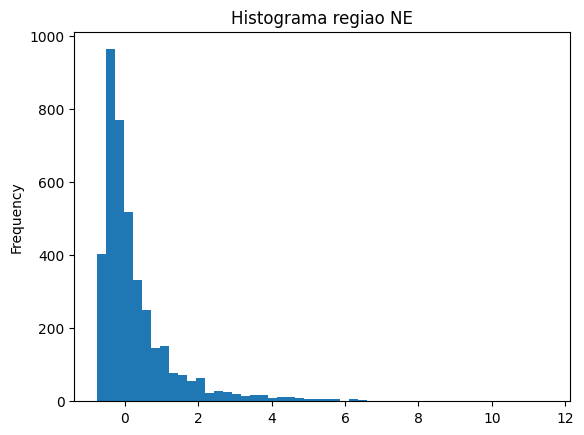


 NE ShapiroResult(statistic=0.6703393459320068, pvalue=0.0) 





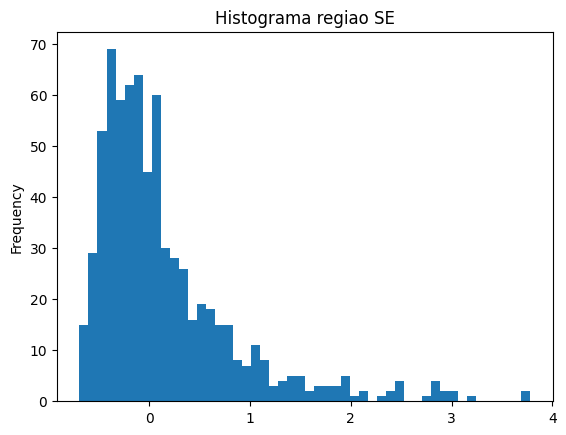


 SE ShapiroResult(statistic=0.8092093467712402, pvalue=3.6643604975561663e-28) 





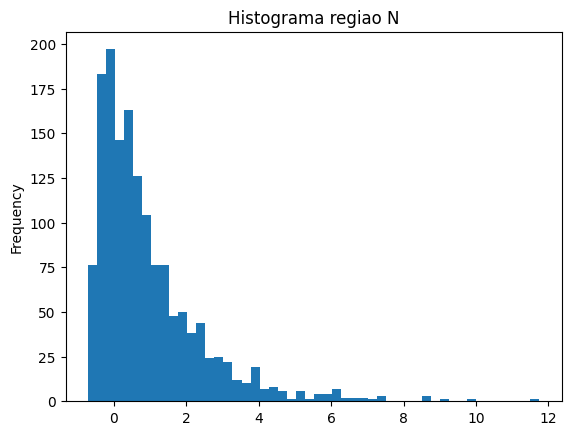


 N ShapiroResult(statistic=0.8095500469207764, pvalue=8.136063599433213e-39) 





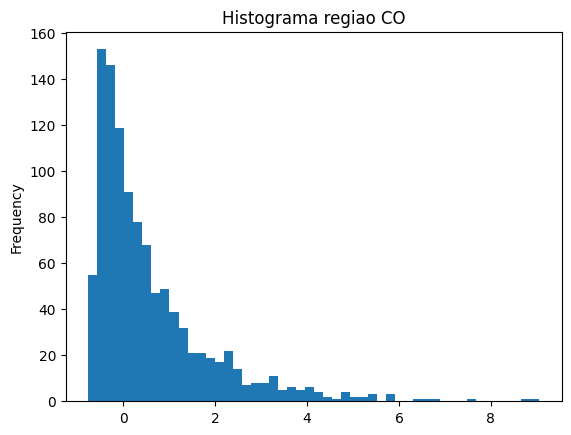


 CO ShapiroResult(statistic=0.789567232131958, pvalue=4.4206531361335677e-35) 





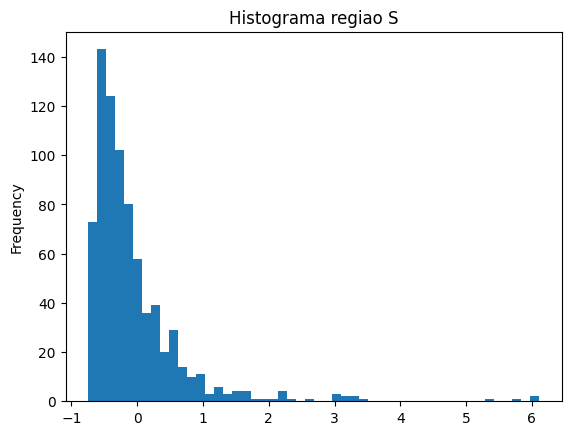


 S ShapiroResult(statistic=0.6579859256744385, pvalue=8.478785722929946e-37) 





In [ ]:
from scipy import stats

for reg in scaled_assent_data['REGIÃO'].unique():
  scaled_assent_data[scaled_assent_data['REGIÃO']==reg]['FAMÍLIAS-ASSENTADAS'].plot(kind='hist', bins=50, title=f'Histograma regiao {reg}')
  plt.show()
  plt.close()
  print('\n', reg, stats.shapiro(scaled_assent_data[scaled_assent_data['REGIÃO']==reg]['FAMÍLIAS-ASSENTADAS']), '\n\n\n')


### Perguntas a serem respondidas

Em contato com o Prof. Bernando Mançano, géografo e professor da UNESP, ele realizou algumas perguntas que são relacionadas a esse dataset. Para respondê-las iremos utilizar o dataset antes da normalização, uma vez que a normalização afeta diretamente as consultas a serem feitas.

1. Quais os 10 tipos predominantes de assentamentos, onde eles estão localizados, qual o número de família e qual a área?
2. Quais os estados com maior número de assentamentos?
3. Quais os estados com maior número de famílias?
4. Número de assentamentos por década
5. Número de assentamentos por governos a partir da década de 1980 até 2022

#### Quais são os 10 tipos predominantes de assentamentos?

<ipython-input-56-df639aa5cf13>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=tipos.index, y=tipos, palette='deep')


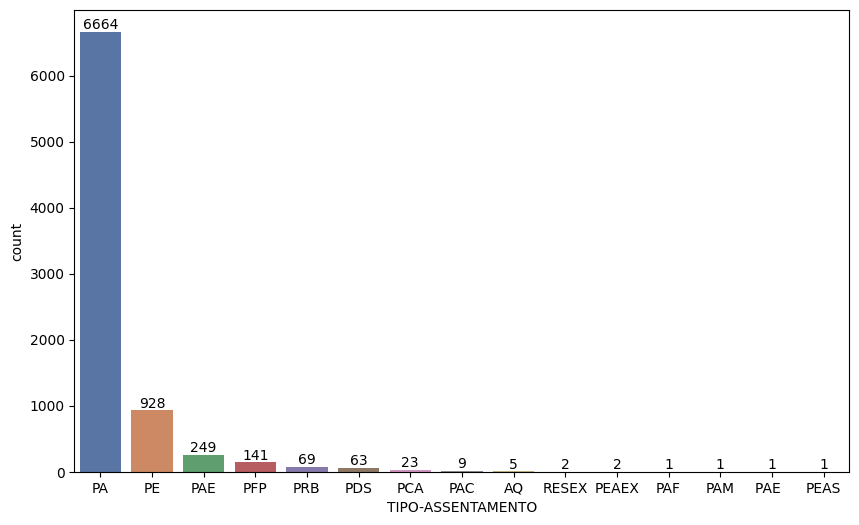

Tipo: PA

UFs que estão presentes assentamentos do tipo PA:  ['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RN' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO'] 

Total de famílias que vivem em assentamento do tipo PA:  453193 

Área total de todos assentamento do tipo PA em hectares 17209111 

----------------------------------------------------------------------------------------------------------------

Tipo: PE

UFs que estão presentes assentamentos do tipo PE:  ['AC' 'AP' 'CE' 'DF' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA' 'PB' 'PE' 'PI' 'PR'
 'RJ' 'RN' 'RS' 'SC' 'SE' 'SP' 'TO'] 

Total de famílias que vivem em assentamento do tipo PE:  45295 

Área total de todos assentamento do tipo PE em hectares 1539944 

----------------------------------------------------------------------------------------------------------------

Tipo: PAE

UFs que estão presentes assentamentos do tipo PAE:  ['AC' 'AM' 'AP' 'MA' 'MG' 'PA'] 

Total de famílias que vivem em assentam

In [ ]:
from math import ceil

tipos = assent_data_back_cat['TIPO-ASSENTAMENTO'].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=tipos.index, y=tipos, palette='deep')
for i, valor in enumerate(tipos):
    ax.text(i, valor + 1, str(valor), ha='center', va='bottom')
plt.show()
print()
for tipo in tipos.index[:10]:
  print(f'Tipo: {tipo}\n')
  print(f'UFs que estão presentes assentamentos do tipo {tipo}: ', assent_data_back_cat[assent_data_back_cat['TIPO-ASSENTAMENTO'] == tipo]['UF'].unique(), '\n')
  print(f'Total de famílias que vivem em assentamento do tipo {tipo}: ', ceil(assent_data_back_cat[assent_data_back_cat['TIPO-ASSENTAMENTO'] == tipo]['FAMÍLIAS-ASSENTADAS'].sum()), '\n')
  print(f'Área total de todos assentamento do tipo {tipo} em hectares', ceil(assent_data_back_cat[assent_data_back_cat['TIPO-ASSENTAMENTO'] == tipo]['ÁREA-(HECTARES)'].sum()), '\n')
  print('----------------------------------------------------------------------------------------------------------------\n')

#### Quais são os estados com maior número de assentamentos?

<ipython-input-96-b5539fdd8d24>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ufs.index, y=ufs, palette='deep')


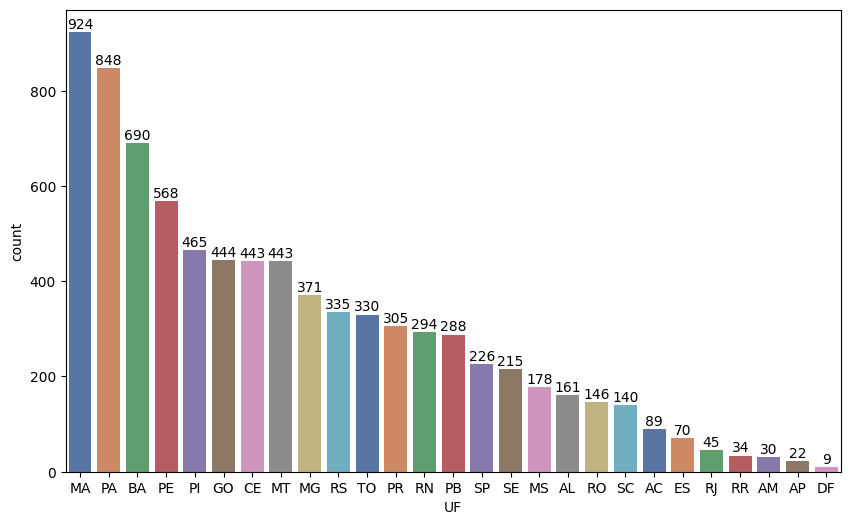

In [ ]:
ufs = assent_data_back_cat['UF'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=ufs.index, y=ufs, palette='deep')
for i, valor in enumerate(ufs):
    ax.text(i, valor + 1, str(valor), ha='center', va='bottom')

plt.show()

Vemos que Maranhão é o estado com maior número de assentamentos do Brasil. Seguido do Pará e da Bahia. Podemos plotar esses dados em um mapa para uma obter uma visualização mais descritiva:

In [ ]:
# Contar a frequência de cada estado
state_counts = assent_data_back_cat['UF'].value_counts().reset_index()
state_counts.columns = ['UF', 'NUM-UF']

state_counts.head()

,UF,NUM-UF
0,MA,924
1,PA,848
2,BA,690
3,PE,568
4,PI,465


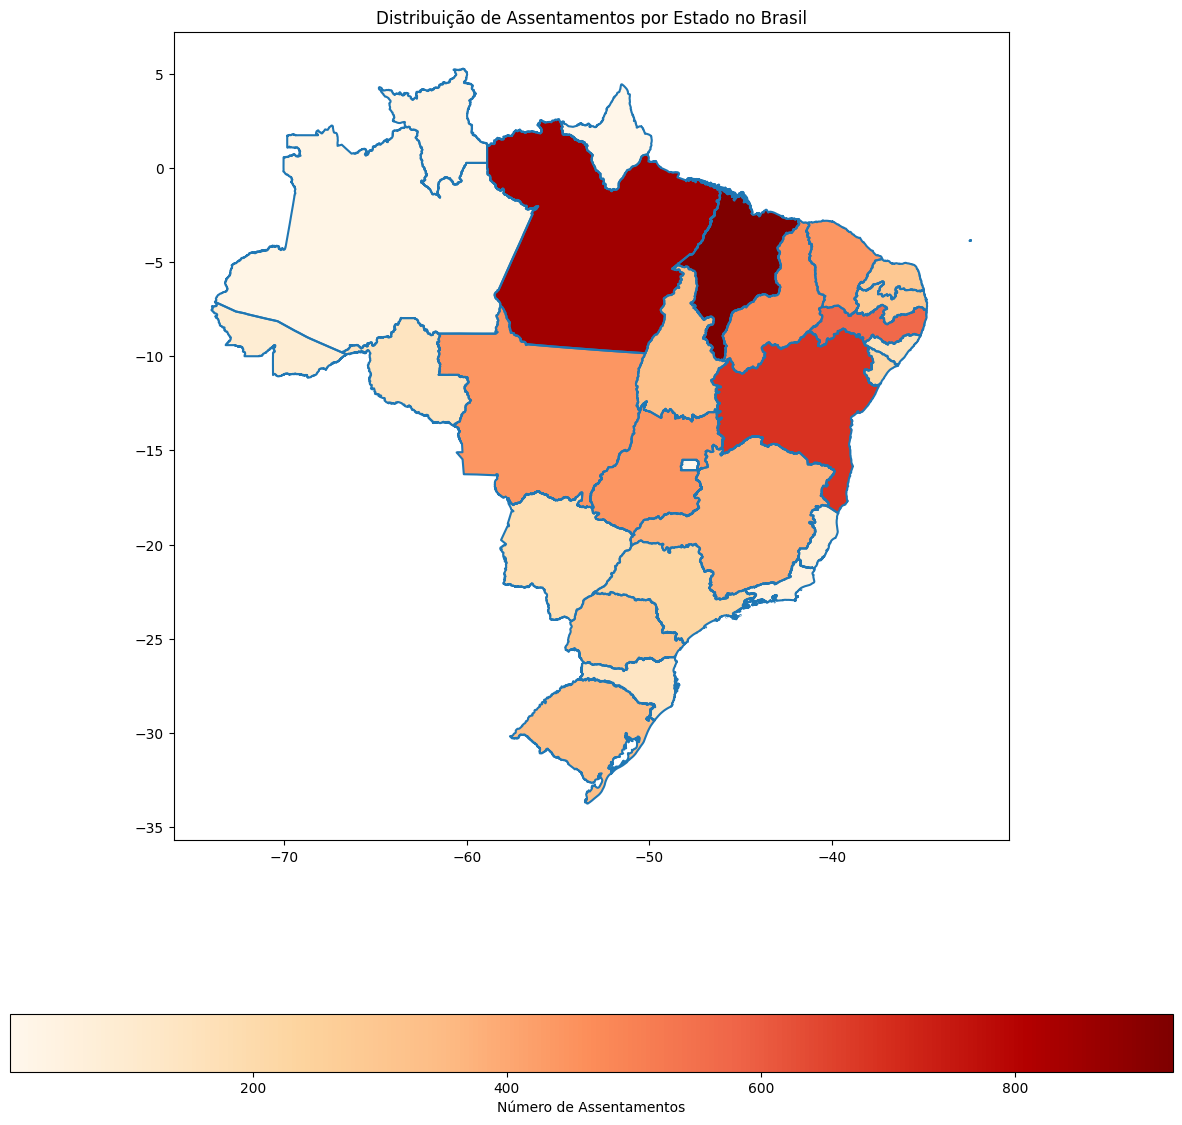

In [ ]:
# Carrega o shapefile do Brasil
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brasil = gpd.read_file(url)

# Renomear coluna para facilitar merge
brasil = brasil.rename(columns={'sigla': 'UF'})

# Realiza o merge considerando os dados nas colunas'UF'
brasil = brasil.merge(state_counts, on='UF', how='left')

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
brasil.boundary.plot(ax=ax)
brasil.plot(column='NUM-UF', ax=ax, legend=True,
            legend_kwds={'label': "Número de Assentamentos",
                         'orientation': "horizontal"},
            cmap='OrRd')

plt.title('Distribuição de Assentamentos por Estado no Brasil')
plt.show()

Também podemos ver a porcentagem de cada região nesses dados.

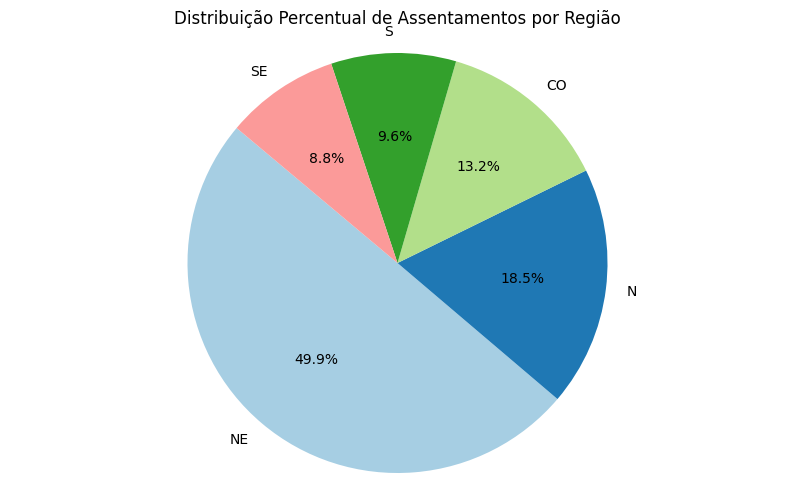

In [ ]:
region_counts = assent_data_back_cat['REGIÃO'].value_counts().reset_index()

total = region_counts['count'].sum()
region_counts['PERCENTAGE'] = (region_counts['count'] / total) * 100

# Dados para o gráfico de pizza
labels = region_counts['REGIÃO']
sizes = region_counts['PERCENTAGE']

# Plotar o gráfico de pizza
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribuição Percentual de Assentamentos por Região')
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.
plt.show()

Notamos que a maior quantidade de assentamentos está presente na região Nordeste, com quase metade de todos os assentamentos no Brasil. E ao cruzar com o mapa, conseguimos perceber que essa distribuição é um pouco homogênea. Ao contrário do Norte, que está em segundo lugar mas em que os assentamentos estão majoritariamente concentrados em apenas um estado (PA).

#### Quais os estados com maior número de famílias?

<ipython-input-61-dbbf6ac1e17b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ufs, y=familias, palette='deep')


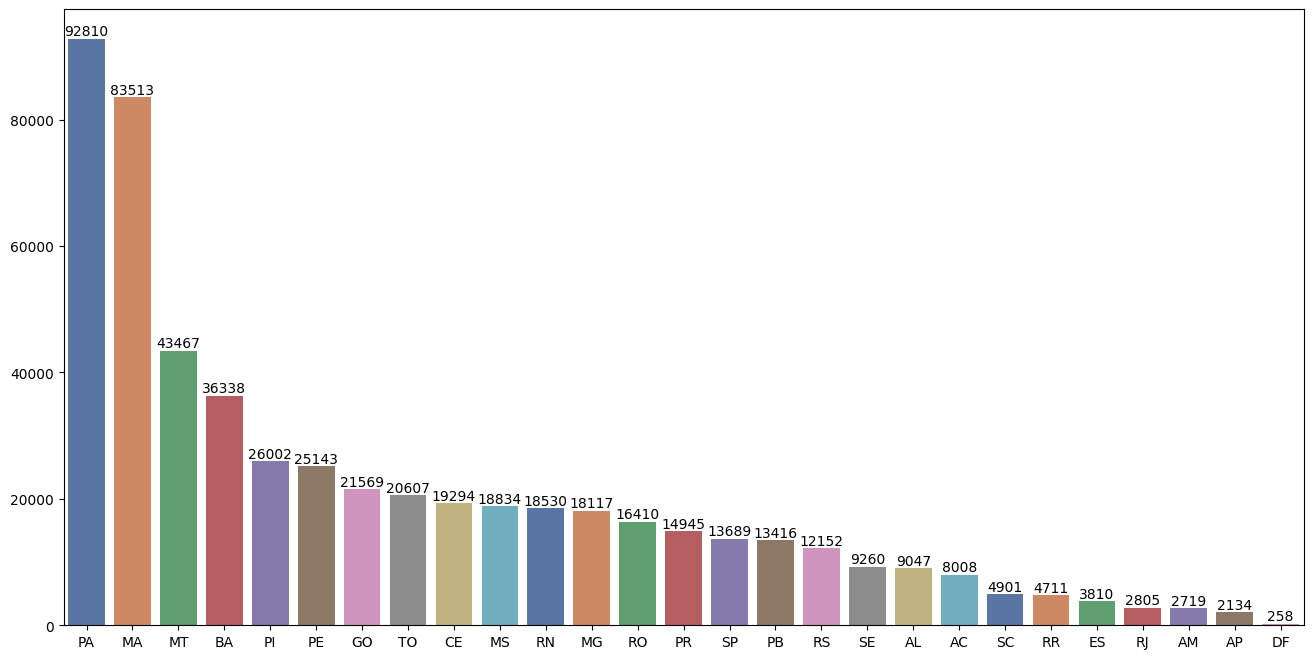

In [ ]:
import pprint
uf_fam = []
for uf in assent_data_back_cat['UF'].unique():
  uf_fam.append((uf, ceil(assent_data_back_cat[assent_data_back_cat['UF'] == uf]['FAMÍLIAS-ASSENTADAS'].sum())))

uf_fam_sorted = sorted(uf_fam, key=lambda x: x[1])[::-1]
ufs, familias = zip(*uf_fam_sorted)

plt.figure(figsize=(16, 8))
ax = sns.barplot(x=ufs, y=familias, palette='deep')

for i, valor in enumerate(familias):
    ax.text(i, valor + 1, str(valor), ha='center', va='bottom')
plt.show()

Constatamos que o estado com o maior de números assentada é o Pará, seguido do Maranhão e Mato Grosso.

#### Número de assentamentos por década

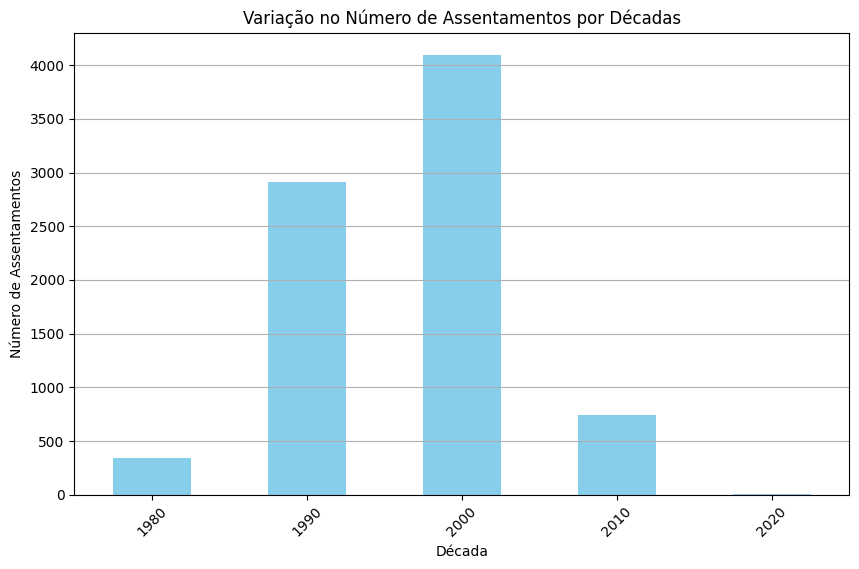

In [ ]:
# Extração da década a partir do ano de criação
assent_data_back_cat['Década'] = (assent_data_back_cat['ANO-CRIAÇÃO'] // 10) * 10

# Contagem do número de assentamentos por década
assentamentos_por_decada = assent_data_back_cat['Década'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
assentamentos_por_decada.plot(kind='bar', color='skyblue')
plt.xlabel('Década')
plt.ylabel('Número de Assentamentos')
plt.title('Variação no Número de Assentamentos por Décadas')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostrar o gráfico
plt.show()

1. Década de 1980: Houve um número relativamente pequeno de assentamentos criados nesta década, em torno de 500.

2.	Década de 1990: O número de assentamentos aumentou significativamente, com aproximadamente 3000 assentamentos criados. Essa década é a seguinte à criação do MST. Esse aumento pode ter se dado por conta da consolidação do movimento.

3.	Década de 2000: Esta década apresentou o maior número de assentamentos criados, com um pico de mais de 4000 assentamentos. Esse aumento provavelmente está relacionado a políticas de reforma agrária e programas de desenvolvimento rural implementados durante esse período.

4.	Década de 2010: Houve uma queda acentuada no número de assentamentos, com menos de 1000 assentamentos criados.

5.	Década de 2020: O número de assentamentos é praticamente insignificante até o momento.

#### Número de assentamentos por governos a partir da década de 1980 até 2022

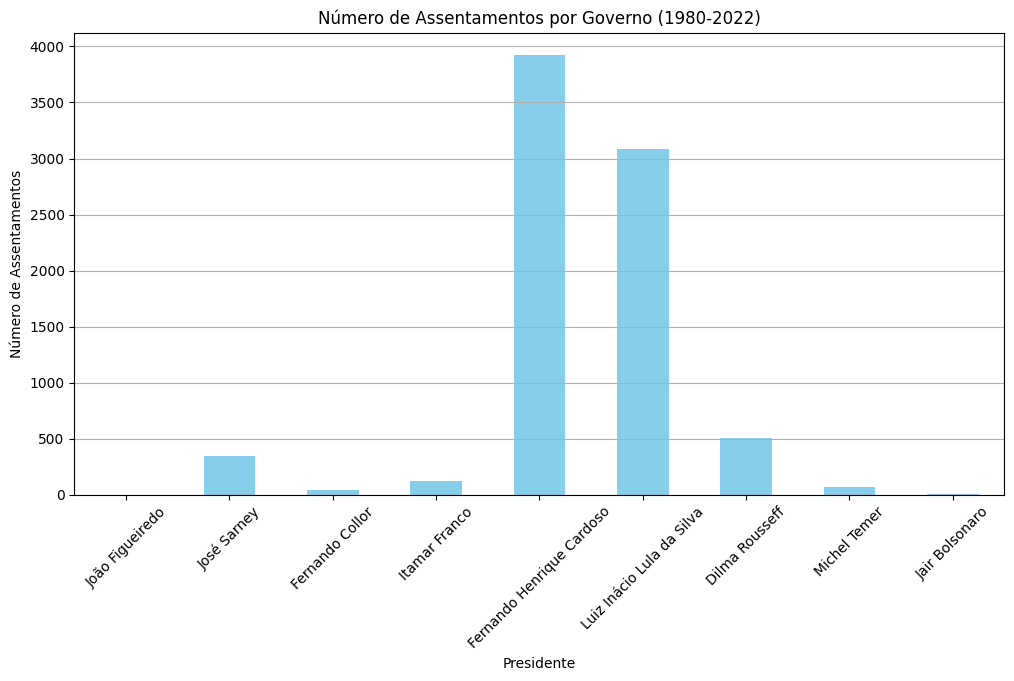

In [ ]:
# Definir os períodos de governo
periodos = [
    ('João Figueiredo', 1979, 1985),
    ('José Sarney', 1985, 1990),
    ('Fernando Collor', 1990, 1992),
    ('Itamar Franco', 1992, 1995),
    ('Fernando Henrique Cardoso', 1995, 2003),
    ('Luiz Inácio Lula da Silva', 2003, 2011),
    ('Dilma Rousseff', 2011, 2016),
    ('Michel Temer', 2016, 2019),
    ('Jair Bolsonaro', 2019, 2022)
]

# Criar uma coluna para armazenar os nomes dos presidentes
assent_data_back_cat['Presidente'] = None

# Atribuir o nome do presidente correspondente a cada assentamento
for presidente, inicio, fim in periodos:
    mask = (assent_data_back_cat['ANO-CRIAÇÃO'] >= inicio) & (assent_data_back_cat['ANO-CRIAÇÃO'] <= fim)
    assent_data_back_cat.loc[mask, 'Presidente'] = presidente

# Contagem do número de assentamentos por presidente
assentamentos_por_presidente = assent_data_back_cat['Presidente'].value_counts().reindex([p[0] for p in periodos])

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
assentamentos_por_presidente.plot(kind='bar', color='skyblue')
plt.xlabel('Presidente')
plt.ylabel('Número de Assentamentos')
plt.title('Número de Assentamentos por Governo (1980-2022)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostrar o gráfico
plt.show()

Notamos que foi no governo de Fernando Henrique Cardoso que houve o maior número de criação de assentamentos rurais no Brasil. Seguido por Lula e Dilma. Esses dados explicam o grande número de assentamentos nos anos 90-2000.

Podemos observar as porcentagens para ter uma compreensão melhor dessa distribuição.

In [ ]:
percentual_assentamentos_por_presidente

Presidente
João Figueiredo               0.024652
José Sarney                   4.252434
Fernando Collor               0.554665
Itamar Franco                 1.553063
Fernando Henrique Cardoso    48.379145
Luiz Inácio Lula da Silva    38.062369
Dilma Rousseff                6.212252
Michel Temer                  0.850487
Jair Bolsonaro                0.110933
Name: count, dtype: float64

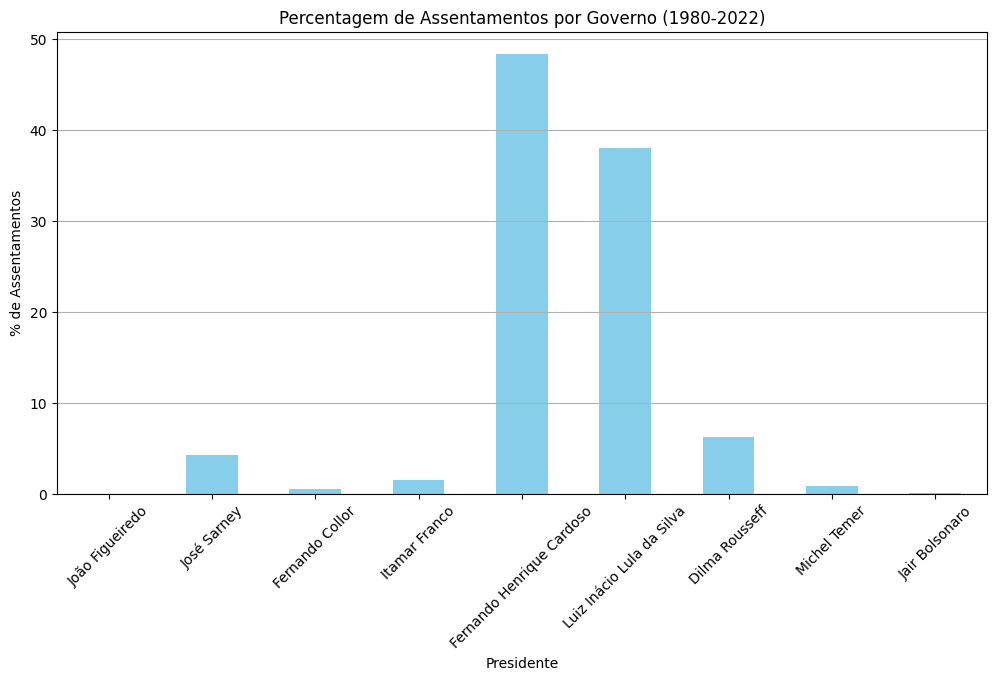

In [ ]:
# Calcular a porcentagem do número de assentamentos por presidente
percentual_assentamentos_por_presidente = (assentamentos_por_presidente / assentamentos_por_presidente.sum()) * 100

plt.figure(figsize=(12, 6))
percentual_assentamentos_por_presidente.plot(kind='bar', color='skyblue')
plt.xlabel('Presidente')
plt.ylabel('% de Assentamentos')
plt.title('Percentagem de Assentamentos por Governo (1980-2022)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostrar o gráfico
plt.show()

In [ ]:
# Printar as percentagens em texto
for presidente, percentual in percentual_assentamentos_por_presidente.items():
    print(f'{presidente}: {percentual:.1f}%')

João Figueiredo: 0.0%
José Sarney: 4.3%
Fernando Collor: 0.6%
Itamar Franco: 1.6%
Fernando Henrique Cardoso: 48.4%
Luiz Inácio Lula da Silva: 38.1%
Dilma Rousseff: 6.2%
Michel Temer: 0.9%
Jair Bolsonaro: 0.1%


Enquanto que os governos de FHC e Lula foram os períodos de maior criação de Assentamentos, os períodos de João Figuereido e de Jair Bolsonaro foram os menores.

Assim, podemos perceber quais governos destinou mais recursos para reforma agrária e quais foram menos favoráveis.

# Tabela 2

## Leitura da Tabela

In [ ]:
# A leitura está ignorando a primeira linha (`skiprows=[0]`) porque é apenas um cabeçalho.
estrang_data = pd.read_excel("/content/drive/MyDrive/data-analysis/Estrangerização.xlsx", skiprows=[0])

## Overview dos Dados e Ajuste da Tabela




Inicialmente, observaremos os dados que foram lidos da tabela.

In [ ]:
estrang_data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Nº,RAZÃO SOCIAL,EMPRESAS E FUNDOS RELACIONADOS,ORIGEM DO CAPITAL,TIPOS DE EXTRATIVISMO,TIPOS DE COMMODITIES,UF
1,1,Abengoa Bioenergia,Abengoa Bioenergia Trading Brasil Ltda.,Espanha,Agrícola,Cana-de-açúcar,SP
2,2,Adecoagro Brasil Participações S. A.,Angélica Agroenergia Ltda.,EUA,Agrícola,Cana-de-açúcar,BA; MG; MS; TO
3,3,ADM do Brasil Ltda.,N.I,EUA,Agricola,Algodão; Soja,BA; GO; MG; MS; MT; PA; PR; RS; SC; TO
4,4,Agrex do Brasil S.A.,Ceagro; Los Grobo; Mitsubishi,Argentina; Japão,Agricola,Soja; Milho,BA; GO; MS; MT; PR; RS; SP; TO


### Limpeza de colunas e de linhas

Como vemos, os dados precisam passar por um tratamento antes de ser analisado.

In [ ]:
# Define primeira linha como nome das colunas
estrang_data.columns = estrang_data.iloc[0]
estrang_data = estrang_data[1:].copy()

# Substitui espaço em branco no nome das colunas por '-'
estrang_data.columns = estrang_data.columns.str.replace(' ', '-', regex=True)

# Como o dataframe já possui indexação, a primeira coluna pode ser removida
estrang_data.drop(columns=estrang_data.columns[0], axis=1, inplace=True)

# Não usaremos a coluna 'EMPRESAS-E-FUNDO-RELACIONADOS' na nossa análise e,
# portanto, ela pode ser removida
estrang_data.drop(['EMPRESAS-E-FUNDOS-RELACIONADOS'], axis=1, inplace=True)

# Reseta index
estrang_data.reset_index(drop=True, inplace=True)

A tabela possui alguns dados não preenchidos. Esses dados estão sendo referenciados como 'N.I' ou 'N.I.'. Para facilitar a manipulação do dataframe iremos substituí-los por `np.nan`.

In [ ]:
estrang_data.replace(['N.I', 'N.I.'], np.nan, inplace=True)

Também transformaremos todas as strings para caixa baixa.

In [ ]:
estrang_data = estrang_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

Agora, podemos ver como estão os dados após esse tratamento inicial.

In [ ]:
estrang_data.head()

,RAZÃO-SOCIAL,ORIGEM-DO-CAPITAL,TIPOS-DE-EXTRATIVISMO,TIPOS-DE-COMMODITIES,UF
0,abengoa bioenergia,espanha,agrícola,cana-de-açúcar,sp
1,adecoagro brasil participações s. a.,eua,agrícola,cana-de-açúcar,ba; mg; ms; to
2,adm do brasil ltda.,eua,agricola,algodão; soja,ba; go; mg; ms; mt; pa; pr; rs; sc; to
3,agrex do brasil s.a.,argentina; japão,agricola,soja; milho,ba; go; ms; mt; pr; rs; sp; to
4,agrícola xingu,japão; reino unido,agricola,algodao; soja; milho; terra,ba; go; mg; mt


### Ajusta valores múltiplos

As colunas apresentam múltiplos valores para uma mesma linha. Por exemplo, temos o valor 'ba; go; mg; ms; mt; pa; pr; rs; sc; to' para UF na posição 2.

Esses valores, por sua vez, não estão seguindo um padrão de organização. Iremos dividir os valores por ',' para facilitar a análise.

In [ ]:
def replace_semicolon_with_comma(df, column_name):
  column = df[column_name]
  column = column.str.strip()
  column = column.str.replace(';', ',', regex=True)
  column = column.str.replace(', ', ',', regex=True)
  column = column.str.replace(' ,', ',', regex=True)
  return column

#### Razão Social

In [ ]:
estrang_data["RAZÃO-SOCIAL"] = replace_semicolon_with_comma(estrang_data, "RAZÃO-SOCIAL")
estrang_data["RAZÃO-SOCIAL"].unique()

array(['abengoa bioenergia', 'adecoagro brasil participações s. a.',
       'adm do brasil ltda.', 'agrex do brasil s.a.', 'agrícola xingu',
       'agropecuária arakatu ltda.', 'agroreservas do brasil ltda.',
       'alcotra bio energy do brasil s.a.',
       'amaggi & ld commodities s.a.',
       'anglo american minerio de ferro brasil s/a.', 'aes brasil ltda',
       'arauco do brasil s. a.', 'arauco florestal arapoti s.a.',
       'atlantic energias renováveis', 'atlas renewable energy', 'atvos',
       'azenglever agropecuária ltda - me',
       'bahia speciality cellusose s.a.,bracell sp celulose ltda',
       'belem bionergia brasil s.a.', 'belo sun mineração ltda.',
       'biosev bionergia s.a.', 'biourja do brasil agroindustria ltda.',
       'brk ambiental participações s/a,brookfield brasil ltda',
       'brasilagro', 'brazil iowa farms ltda.- me',
       'potengi foldings s.a.', 'british petroleum biofuels',
       'brookfield asset management,elera renováveis participaçõe

#### Origem do Capital

Nas demais colunas iremos criar um dicionário com correção de palavras para poder corrigir valores com typos.

In [ ]:
estrang_data["ORIGEM-DO-CAPITAL"] = replace_semicolon_with_comma(estrang_data, "ORIGEM-DO-CAPITAL")
estrang_data["ORIGEM-DO-CAPITAL"] = estrang_data["ORIGEM-DO-CAPITAL"].str.replace('\*', '', regex=True)

# Substituição de itens de mesmo nome mas com desvio na escrita
replacement_dict = {
    'canada': 'canadá',
    'indonesia': 'indonésia',
    'india': 'índia',
    'reino unido: eua': 'reino unido,eua',
    'brasil\n áustria': 'brasil,áustria',
    'eua/brasil': 'eua,brasil'
}

for key, value in replacement_dict.items():
  estrang_data['ORIGEM-DO-CAPITAL'] = estrang_data['ORIGEM-DO-CAPITAL'].str.replace(key, value)


estrang_data["ORIGEM-DO-CAPITAL"].unique()

array(['espanha', 'eua', 'argentina,japão', 'japão,reino unido', 'japão',
       'bélgica', 'brasil,argentina', 'reino unido', 'chile', 'chile,eua',
       'brasil,eua,japão,reino unido', 'finlândia,suécia',
       'singapura,indonésia', 'portugal', 'canadá', 'frança',
       'brasil,canadá', 'argentina,brasil', 'argentina,eua',
       'eua,países baixos', 'brasil,eua', 'china', 'irlanda',
       'chile,reino unido,eua', 'alemanha,brasil', 'argélia', 'itália',
       'coreia do sul', 'brasil', 'eua,reino unido',
       'brasil,espanha,japão', 'nova zelândia', 'reino unido,brasil',
       'países baixos', 'portugal,brasil,portugal,frança,itália',
       'argentina,reino unido', 'indonésia', 'eua,frança',
       'canadá,eua,brasil', 'noruega', 'dinamarca', 'brasil,singapura',
       'portugual', 'reino unido,suíça', 'reino unido,suíça,brasil',
       'eua,brasil', 'brasil,frança', 'áustria', 'eua,paraguai',
       'eua,catar', 'paraguai', 'panama', 'eua,japão', 'brasil,áustria',
       '

#### Tipos de Extrativismo

In [ ]:
estrang_data["TIPOS-DE-EXTRATIVISMO"] = replace_semicolon_with_comma(estrang_data, "TIPOS-DE-EXTRATIVISMO")

# Substituição de itens de mesmo nome mas com desvio na escrita
replacement_dict = {
    'agricola': 'agrícola',
    'agrícola****': 'outros agrícola',
    'energias': 'energia'
}

for key, value in replacement_dict.items():
  estrang_data['TIPOS-DE-EXTRATIVISMO'] = estrang_data['TIPOS-DE-EXTRATIVISMO'].str.replace(key, value)

estrang_data["TIPOS-DE-EXTRATIVISMO"].unique()

array(['agrícola', 'mineral', 'energia', 'silvicultura',
       'agrícola,natureza,energia,silvicultura', 'agrícola,energia',
       'natureza,agrícola', 'outros agrícola', 'energia,natureza',
       'combustíveis fósseis', 'natureza', 'silvicultura,agrícola', nan],
      dtype=object)

#### Tipos de Commodities

In [ ]:
estrang_data["TIPOS-DE-COMMODITIES"] = replace_semicolon_with_comma(estrang_data, "TIPOS-DE-COMMODITIES")

# Substituição de itens de mesmo nome mas com desvio na escrita
replacement_dict = {
    'algodao': 'algodão',
    'cana-de-açucar': 'cana-de-açúcar',
    'cana-de-acucar': 'cana-de-açúcar',
    'grãos (em rotação)*': 'grãos',
    'energia eolica': 'energia eólica',
    'frutas*****': 'frutas',
    'area de preservacao': 'área de preservação',
    'agrícola****': 'agrícola',
    'cafe': 'café',
    'termoeletrica': 'termoelétrica',
    'térmica': 'termoelétrica',
    'petroleo': 'petróleo',
    'gas': 'gás',
    'energias***': 'energias',
    'aluminio': 'alumínio',
    'niquel': 'níquel',
    'hidreletrica': 'hidrelétrica'
}

for key, value in replacement_dict.items():
  estrang_data['TIPOS-DE-COMMODITIES'] = estrang_data['TIPOS-DE-COMMODITIES'].str.replace(key, value)

estrang_data["TIPOS-DE-COMMODITIES"].unique()

array(['cana-de-açúcar', 'algodão,soja', 'soja,milho',
       'algodão,soja,milho,terra', 'algodão,café',
       'feijão,frutas,grãos,monocultivo de árvores', 'soja,milho,algodão',
       'ferro,níquel', 'energia eólica', 'eucalipto', 'celulose,madeira',
       'madeira,celulose,terra', 'madeira,floresta,terra', 'palma',
       'ferro', 'milho', 'energia solar', 'terra',
       'soja,algodão,milho,cana-de-açúcar', 'milho,soja',
       'energia solar,energia eólica,cana-de-açúcar,celulose',
       'soja,milho,cana-de-açúcar', 'cana-de-açúcar,energia eólica',
       'monocultivo de árvores', 'celulose,floresta,terra', 'celulose',
       'grãos', 'algodão', 'energia eólica,energia solar', 'nióbio',
       'pecuária,laticínios', 'frutas',
       'cana-de-açúcar,área de preservação', 'agrícola', 'café',
       'energia solar,energia eólica',
       'energia termoelétrica,floresta,terra,celulose',
       'energia eólica,energia solar,energia hidroelétrica', 'petróleo',
       'petróleo,gás',

#### UF

In [ ]:
estrang_data["UF"] = replace_semicolon_with_comma(estrang_data, "UF")
estrang_data["UF"].unique()

array(['sp', 'ba,mg,ms,to', 'ba,go,mg,ms,mt,pa,pr,rs,sc,to',
       'ba,go,ms,mt,pr,rs,sp,to', 'ba,go,mg,mt', 'ba', 'mg', 'pb',
       'ma,mt', 'go', 'ba,rs,pi,pe', 'ms', 'pr,sc', 'ba,rn,rs',
       'go,ma,mt,ms,sp', 'pr,rs', 'ba,sp', 'pa', 'mg,ms,sp', 'es', 'mt',
       'ba,go,ma,mg,mt,pi', 'rn', 'go,mg', 'mg,ce,ms,rn',
       'ba,go,mg,ms,mt,pi,pr,rs,sc,sp,to', 'pi', 'ba,go,mg', 'mg,ce,pe',
       'go,mg,mt,pi', 'ba,go,ma,mg,ms,mt,pa,pr,sp,to', 'sp,ba,pa', 'am',
       'ma', nan, 'ma,pi,to', 'mg,sp', 'ba,pi,rs', 'rs,sc',
       'ba,go,mg,ms,mt,pr,sc,sp', 'pi,pe', 'rs', 'ce,rn,sp', 'pa,mg',
       'go,mt,rs,to', 'ce,pe,rn', 'mg,ba,go,pb', 'ba,mg,sp',
       'ba,ce,mg,ms,rn,pb,pi,pr,ro,rs,sc,sp', 'sp,pb', 'ba,mg,pr',
       'ms,mt,go', 'mg,rn', 'ba,pe,pi,rn,go,pa,rr,ce', 'pr', 'ba,mg,rn',
       'sp,rj', 'pe', 'ba,es,mg,ms,rs,sp', 'mt,pa', 'se', 'mt,sp',
       'sp,pr', 'mg,pi', 'ba,rn,rs,pi,pe', 'sp,to', 'sp,rj,df,rn,pi',
       'al', 'ba,es,mg,ms', 'ma,pi', 'ba,mg,ms,pr,sc,rj,sp,to,m

Agora, com os dados múltiplos organizados, iremos remover os valores duplicados

In [ ]:
print("Quantidade de linhas antes da remoção de itens duplicados:", estrang_data.shape[0])

estrang_data.drop_duplicates(inplace=True)

print("Quantidade de linha depois da remoção de itens duplicados:", estrang_data.shape[0])

Quantidade de linhas antes da remoção de itens duplicados: 208
Quantidade de linha depois da remoção de itens duplicados: 207


Agora, com os dados tratados, vamos observar o dataframe.

In [ ]:
estrang_data.head(10)

,RAZÃO-SOCIAL,ORIGEM-DO-CAPITAL,TIPOS-DE-EXTRATIVISMO,TIPOS-DE-COMMODITIES,UF
0,abengoa bioenergia,espanha,agrícola,cana-de-açúcar,sp
1,adecoagro brasil participações s. a.,eua,agrícola,cana-de-açúcar,"ba,mg,ms,to"
2,adm do brasil ltda.,eua,agrícola,"algodão,soja","ba,go,mg,ms,mt,pa,pr,rs,sc,to"
3,agrex do brasil s.a.,"argentina,japão",agrícola,"soja,milho","ba,go,ms,mt,pr,rs,sp,to"
4,agrícola xingu,"japão,reino unido",agrícola,"algodão,soja,milho,terra","ba,go,mg,mt"
5,agropecuária arakatu ltda.,japão,agrícola,"algodão,café",ba
6,agroreservas do brasil ltda.,eua,agrícola,"feijão,frutas,grãos,monocultivo de árvores",mg
7,alcotra bio energy do brasil s.a.,bélgica,agrícola,cana-de-açúcar,pb
8,amaggi & ld commodities s.a.,"brasil,argentina",agrícola,"soja,milho,algodão","ma,mt"
9,anglo american minerio de ferro brasil s/a.,reino unido,mineral,"ferro,níquel",go


## Análise Descritiva

Uma vez com os dados "limpos", podemos responder algumas perguntas levantadas. Essas perguntas também foram feitas pelo Prof. Bernardo Mançano Fernandes, geográfo e professor na UNESP.




### Quais são as principais corporações na aquisicação de terras no Brasil?

Iremos considerar como principais corporações aquelas que estão presentes em mais estados do Brasil, uma vez que informações como extensão de área e valor investido não estão presente na tabela.

In [ ]:
# Expandir a coluna 'UF' para separar linhas para cada estado e remover instâncias nulas
data_expanded = estrang_data.assign(UF=estrang_data['UF'].str.split(',')).explode('UF')
data_expanded.dropna(inplace=True)

# Agrupar por 'RAZÃO-SOCIAL' e contar os estados distintos
company_counts = data_expanded.groupby('RAZÃO-SOCIAL')['UF'].nunique().reset_index()
company_counts = company_counts.rename(columns={'UF': 'NUM-ESTADOS'})

# Ordenar os dados para facilitar a visualização das principais corporações
company_counts = company_counts.sort_values(by='NUM-ESTADOS', ascending=False, ignore_index=True)

# Exibir as principais corporações
company_counts.head(5)

,RAZÃO-SOCIAL,NUM-ESTADOS
0,edp renováveis brasil,12
1,bunge alimentos s.a.,11
2,klabin s.a.,11
3,cargill agrícola s.a.,10
4,adm do brasil ltda.,10


Podemos ver a distribuição dos dados para ter um entendimento melhor destes.

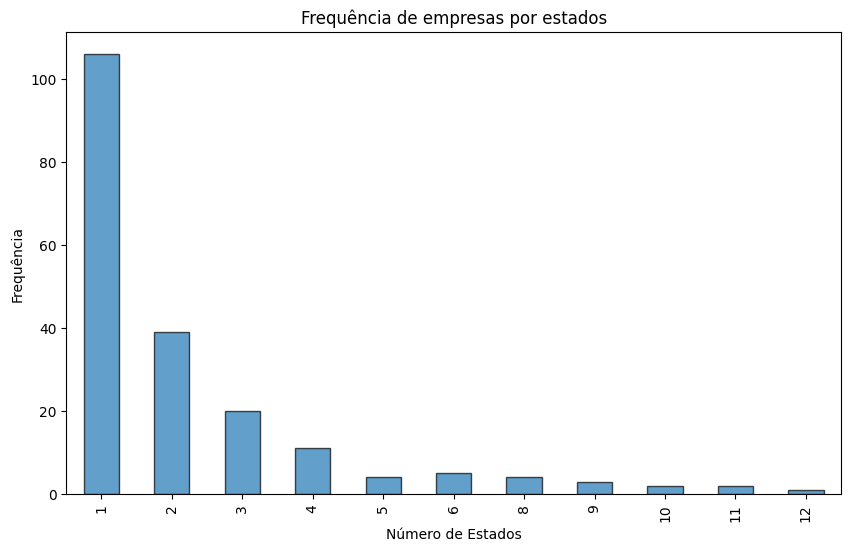

In [ ]:
# Plotar gráfico de barras para a frequência de 'NUM-ESTADOS'
plt.figure(figsize=(10, 6))
company_counts['NUM-ESTADOS'].value_counts().sort_index().plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Frequência de empresas por estados')
plt.xlabel('Número de Estados')
plt.ylabel('Frequência')
plt.show()

Podemos perceber que a maioria das empresas está presente em 1 estado. Uma pequena parcela está presente em mais de quatro estados distintos.

Observemos a descricação estatística dos dados:

In [ ]:
print("Descrição Estatística dos Dados:")
print(company_counts['NUM-ESTADOS'].describe())

print("\nMediana:", company_counts['NUM-ESTADOS'].median())

Descrição Estatística dos Dados:
count    197.000000
mean       2.289340
std        2.202165
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       12.000000
Name: NUM-ESTADOS, dtype: float64

Mediana: 1.0


Como os dados estão desbalanceados, iremos considerar a mediana ao invés da média na análise. Assim, enquanto a mediana é de um estados por empresa, o máximo é de 12 estados para uma mesma razão social.

Podemos observar um boxplot desses dados, para entender melhor sua distribuição:

<Axes: >

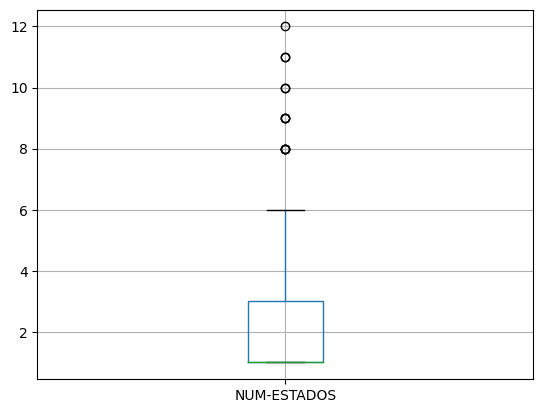

In [ ]:
company_counts.boxplot(column=['NUM-ESTADOS'])

O boxplot confirma nossa sugestão de que a proporção da presença de estados por empresas está desbalanceado e que a maioria das empresas está por volta de 1 a 3 estados brasileiros.

Podemos, então responder a pergunta. Iremos ver quais são as 10 principais corporações estrangeiras na aquisição de terras no Brasil.

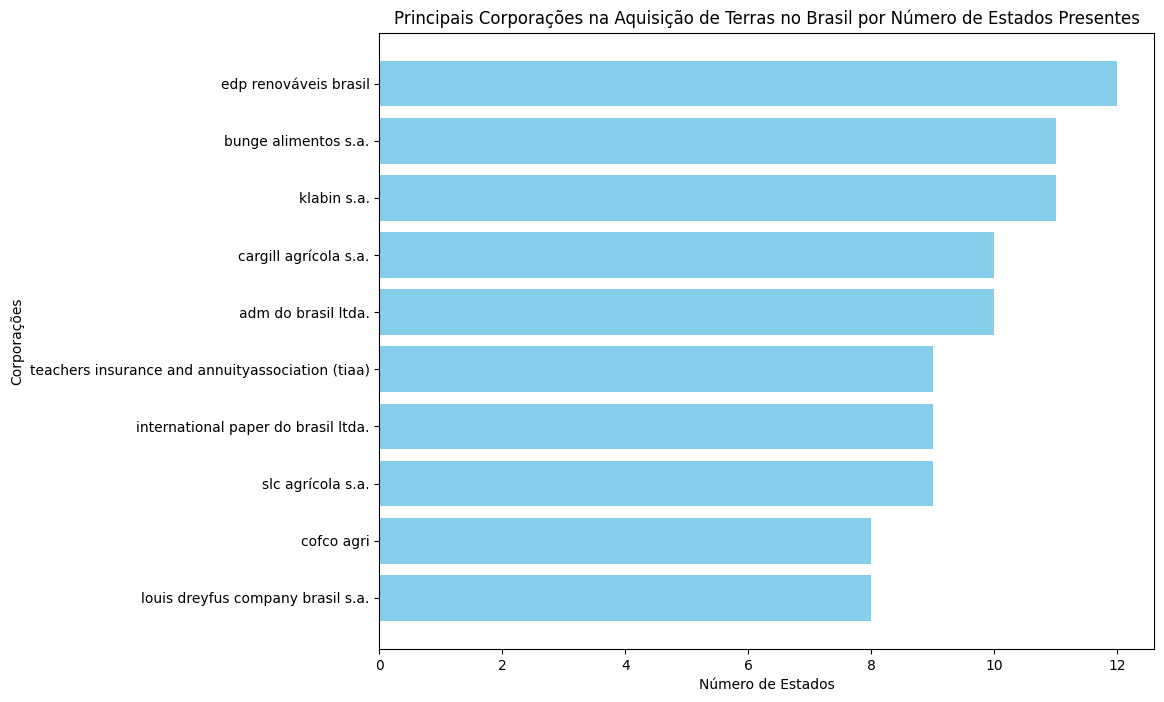

In [ ]:
# Considerando as dez principais corporações
top_ten_corporations = company_counts.head(10)

# Plotar o gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(top_ten_corporations['RAZÃO-SOCIAL'], top_ten_corporations['NUM-ESTADOS'], color='skyblue')
plt.xlabel('Número de Estados')
plt.ylabel('Corporações')
plt.title('Principais Corporações na Aquisição de Terras no Brasil por Número de Estados Presentes')
plt.gca().invert_yaxis()  # Inverter o eixo Y para ter a maior barra no topo
plt.show()

### Qual a origem das empresas estrangeiras?

A pergunta seguinte é: qual é a origem das empresas estrangeiras?

Para poder extrair quais países tem maior investimento, novamente iremos considerar frequência na tabela - uma vez que não dispomos de área ou capital investido.

Vale frisar dado com origem 'Brasil' significa que a empresa está registrada no Brasil, mas a origem do capital é estrangeiro.

In [ ]:
# Expandir a coluna 'ORIGEM-DO-CAPITAL' para separar linhas para cada país
origin_df = estrang_data.assign(**{'ORIGEM-DO-CAPITAL': estrang_data['ORIGEM-DO-CAPITAL'].str.split(',')}).explode('ORIGEM-DO-CAPITAL')

print("Temos um total de", len(origin_df['ORIGEM-DO-CAPITAL'].unique()), "países")
print()
print("Países com terras no Brasil:")
origin_df['ORIGEM-DO-CAPITAL'].unique()

Temos um total de 39 países

Países com terras no Brasil:


array(['espanha', 'eua', 'argentina', 'japão', 'reino unido', 'bélgica',
       'brasil', 'chile', 'finlândia', 'suécia', 'singapura', 'indonésia',
       'portugal', 'canadá', 'frança', 'países baixos', 'china',
       'irlanda', 'alemanha', 'argélia', 'itália', 'coreia do sul',
       'nova zelândia', 'noruega', 'dinamarca', 'portugual', 'suíça',
       'áustria', 'paraguai', 'catar', 'panama', 'emirados árabes unidos',
       'índia', 'nigéria', 'inglaterra', 'holanda', 'israel',
       'ilhas guernsey', ' finlândia'], dtype=object)

In [ ]:
origin_counts = origin_df['ORIGEM-DO-CAPITAL'].value_counts().reset_index(name='NUM-ORIGEM')
origin_counts.head()

,ORIGEM-DO-CAPITAL,NUM-ORIGEM
0,eua,58
1,brasil,48
2,reino unido,21
3,japão,17
4,frança,14


Podemos plotar os dados em um gráfico de barras para possuir uma rápida visualização desses dados.

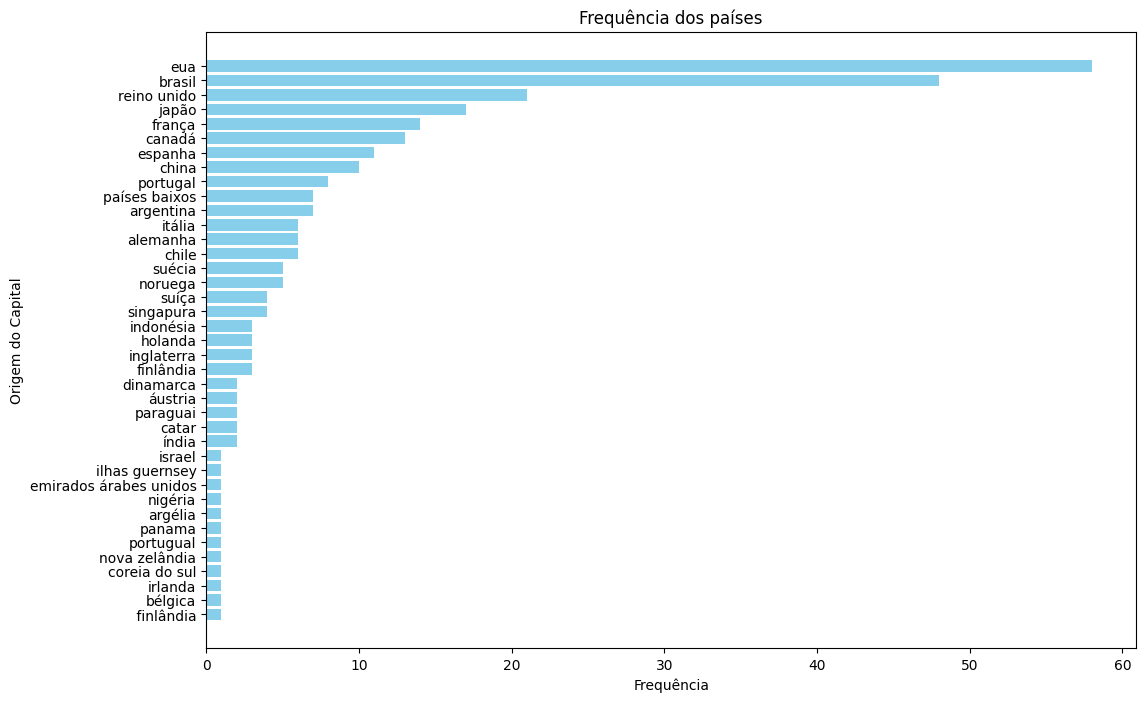

In [ ]:
# Visualização usando um gráfico de barras horizontal
plt.figure(figsize=(12, 8))
plt.barh(origin_counts['ORIGEM-DO-CAPITAL'], origin_counts['NUM-ORIGEM'], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Origem do Capital')
plt.title('Frequência dos países')
plt.gca().invert_yaxis()  # Inverter o eixo Y para ter a maior barra no topo
plt.show()

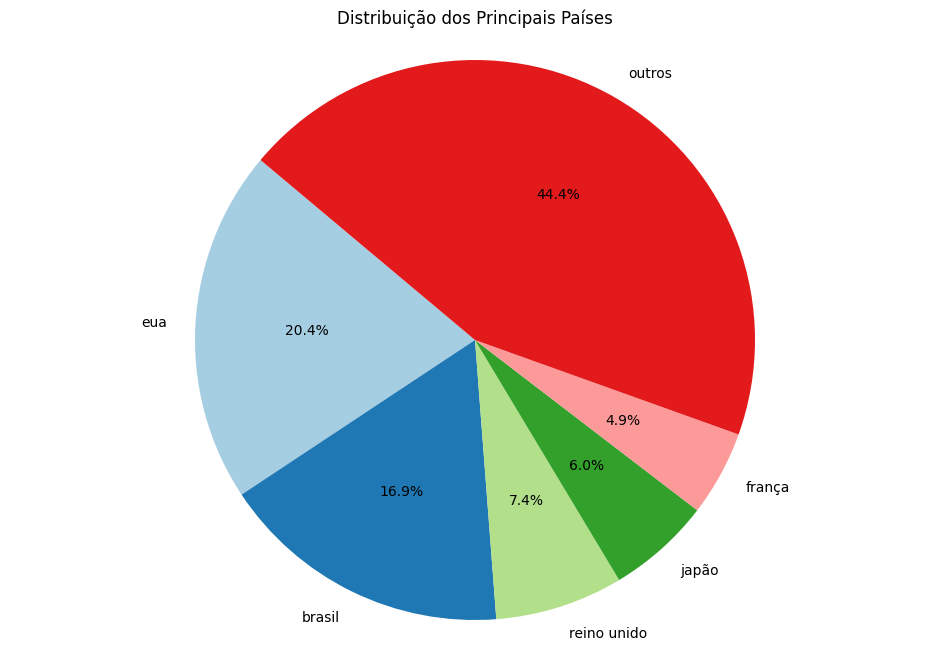

In [ ]:
# Identificar as 5 principais commodities
top_5 = origin_counts.nlargest(5, 'NUM-ORIGEM')

# Agrupar as demais commodities em "Outros"
others = pd.DataFrame([['outros', origin_counts['NUM-ORIGEM'][5:].sum()]], columns=['ORIGEM-DO-CAPITAL', 'NUM-ORIGEM'])

# Combinar as 5 principais commodities com "Outros"
top_5_with_others = pd.concat([top_5, others])

# Criar o gráfico de pizza
plt.figure(figsize=(12, 8))
plt.pie(top_5_with_others['NUM-ORIGEM'], labels=top_5_with_others['ORIGEM-DO-CAPITAL'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribuição dos Principais Países')
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.
plt.show()

### Onde estão (quais regiões e estados) concentrados as principais aquisições de terra para estrangerização?

Para responder a essa pergunta iremos considerar a frequência de cada estado nos dados, uma vez que não temos valores sobre relativos à área e ao capital investido.

In [ ]:
# Iremos pegar a coluna com os estados do dataframe em que dividimos cada estado por linha
states = data_expanded['UF']

# Estados
print("Estados:", data_expanded['UF'].unique())

# Quantidade de Estados:
print("\nTotal de estados:", len(data_expanded['UF'].unique()))

Estados: ['sp' 'ba' 'mg' 'ms' 'to' 'go' 'mt' 'pa' 'pr' 'rs' 'sc' 'pb' 'ma' 'pi'
 'pe' 'rn' 'es' 'ce' 'am' 'ro' 'rr' 'rj' 'se' 'df' 'al']

Total de estados: 25


Criaremos um novo dataframe contendo os estados e a frequência para cada estado.

In [ ]:
# Contar a frequência de cada estado
state_counts = states.value_counts().reset_index()
state_counts.columns = ['UF', 'NUM-UF']

state_counts.head()

,UF,NUM-UF
0,ba,56
1,sp,54
2,mg,50
3,ms,31
4,go,31


Podemos ver a distriuição dos dados para ter um melhor entendimento destes.

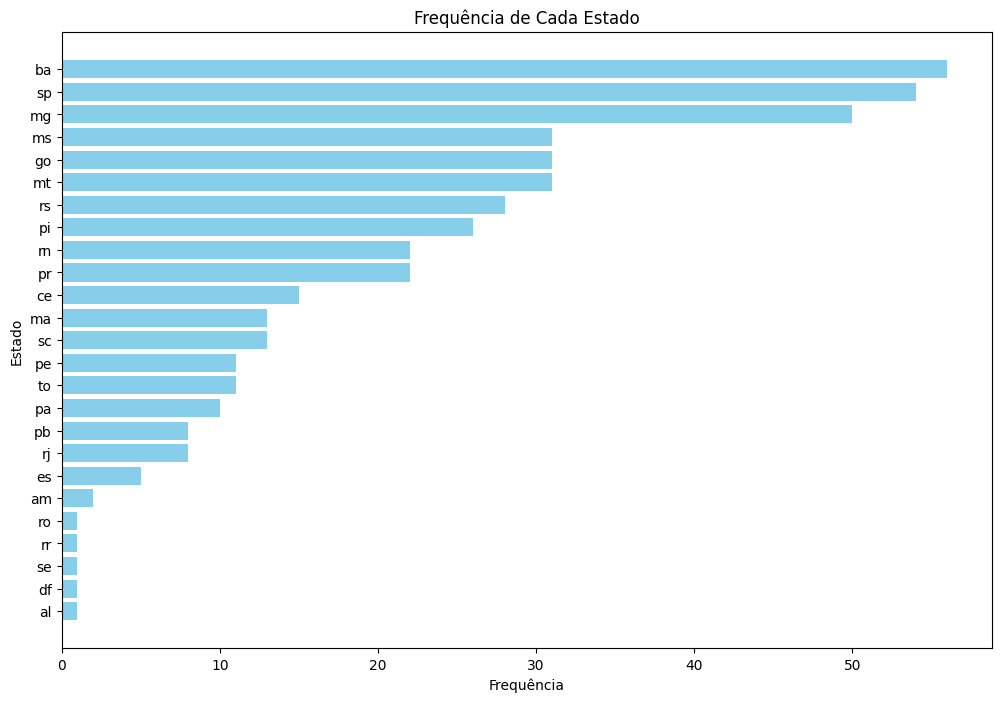

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(state_counts['UF'], state_counts['NUM-UF'], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Estado')
plt.title('Frequência de Cada Estado')
plt.gca().invert_yaxis()
plt.show()

Percebemos que a distribuição de estados não é homogênea, tendo as entradas mais recorrentes tendo valores bastante díspares em relação aos menos recorrentes.

Observemos a descrição estatística dos dados:

In [ ]:
print("Descrição Estatística dos Dados:")
print(state_counts['NUM-UF'].describe())

print("\nMediana:", state_counts['NUM-UF'].median())

Descrição Estatística dos Dados:
count    25.000000
mean     18.080000
std      16.780246
min       1.000000
25%       5.000000
50%      13.000000
75%      28.000000
max      56.000000
Name: NUM-UF, dtype: float64

Mediana: 13.0


Como os dados estão desbalanceados, iremos considerar a medinada ao invés da média na análise. Aqui, temos que o máximo de recorrências para um estado é de 56, enquanto que a mediana é de 13.

Podemos observar um boxplot desses dados, para entender melhor sua distribuição:

<Axes: >

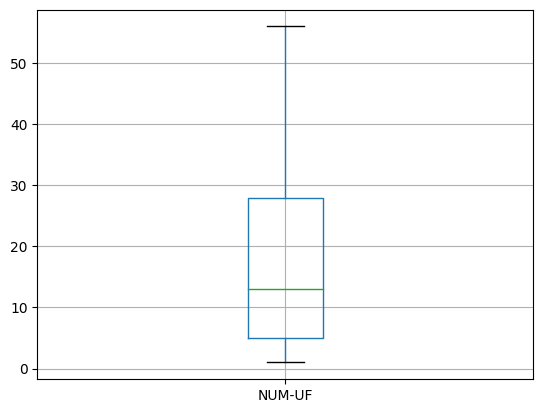

In [ ]:
state_counts.boxplot(column=['NUM-UF'])

Novamente, temos o reforço do desbalanceamento dos dados. Mostrando um alto valor de desvio. No entanto, o bloxpot não indicou nenhum outlier entre os dados.

Para auxiliar na resposta, podemos fazer uma visualização do mapa do Brasil considerando a frequência de entrada para cada estado.

In [ ]:
# Iremos capitalizar as siglas de cada estado
state_counts['UF'] = state_counts['UF'].str.upper()

# Carrega o shapefile do Brasil
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
brasil = gpd.read_file(url)

# Observemos o shapefile
brasil.head()

,id,name,sigla,regiao_id,codigo_ibg,cartodb_id,created_at,updated_at,geometry
0,1,Acre,AC,3,12,1,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-73.60818 -7.20194, -72.86963 ..."
1,2,Alagoas,AL,4,27,2,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-35.46516 -8.82549, -35.46626 ..."
2,3,Amazonas,AM,3,13,3,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-67.32553 2.03012, -67.32234 2..."
3,4,Amapá,AP,3,16,4,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-51.18168 4.00889, -51.17900 3..."
4,5,Bahia,BA,4,29,5,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-39.28820 -8.56290, -39.28229 ..."


In [ ]:
# Renomear coluna para facilitar merge
brasil = brasil.rename(columns={'sigla': 'UF'})

# Realiza o merge considerando os dados nas colunas'UF'
brasil = brasil.merge(state_counts, on='UF', how='left')

# Garantir que não teremos nenhum dado `na`
brasil['NUM-UF'] = brasil['NUM-UF'].fillna(0)

Podemos, então, plotar o mapa.

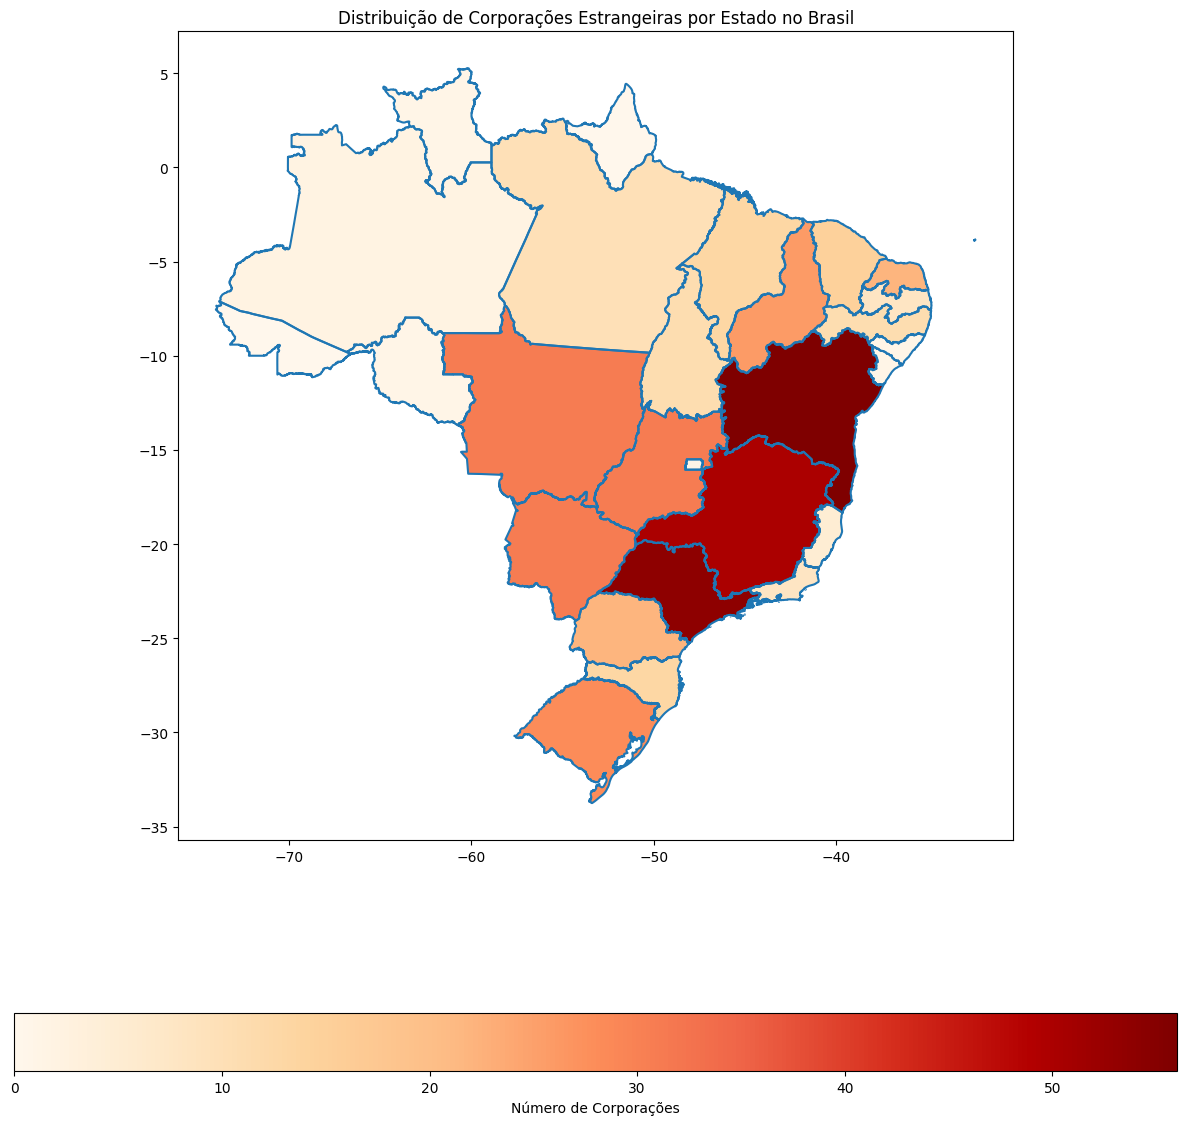

In [ ]:
# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
brasil.boundary.plot(ax=ax)
brasil.plot(column='NUM-UF', ax=ax, legend=True,
            legend_kwds={'label': "Número de Corporações",
                         'orientation': "horizontal"},
            cmap='OrRd')

plt.title('Distribuição de Corporações Estrangeiras por Estado no Brasil')
plt.show()

Desse mapa, podemos afirmar que:

1. Bahia, São Paulo e Minas Gerais são os estados com maiores concentrações de diferentes corporações estrangeiras.
2. Em relação à distribuição regional temos que a preferência é pelo Sudeste. Uma outra região em que a estrangerização também se mostra presente é a região Centro-Oste.
3. A região Norte é a que possui menos diversidade de corporações.

Por fim, podemos ver os dados em percentagem para ter uma outra representação desses dados:

In [ ]:
# Mapeamento dos estados por região
region_by_state = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AM': 'Norte', 'AP': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MG': 'Sudeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'PR': 'Sul', 'RJ': 'Sudeste', 'RN': 'Nordeste', 'RO': 'Norte',
    'RR': 'Norte', 'RS': 'Sul', 'SC': 'Sul', 'SE': 'Nordeste', 'SP': 'Sudeste',
    'TO': 'Norte'
}

# Aplicar o mapeamento no dataframe
state_counts['REGIÃO'] = state_counts['UF'].map(region_by_state)

# Contar o número de ocorrência das regiões
region_counts = state_counts.groupby('REGIÃO')['NUM-UF'].sum().reset_index()
region_counts = region_counts.rename(columns={'NUM-UF': 'NUM-REGIÃO'})

# Criando uma coluna refletindo as porcentagens
total = region_counts['NUM-REGIÃO'].sum()
region_counts['PERCENTAGE'] = (region_counts['NUM-REGIÃO'] / total) * 100

region_counts

,REGIÃO,NUM-REGIÃO,PERCENTAGE
0,Centro-Oeste,94,20.796460
1,Nordeste,153,33.849558
2,Norte,25,5.530973
3,Sudeste,117,25.884956
4,Sul,63,13.938053


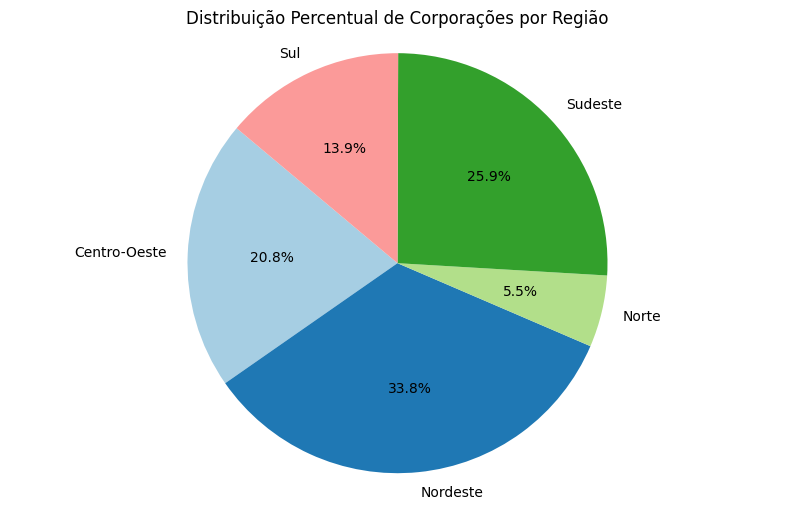

In [ ]:
# Dados para o gráfico de pizza
labels = region_counts['REGIÃO']
sizes = region_counts['PERCENTAGE']

# Plotar o gráfico de pizza
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribuição Percentual de Corporações por Região')
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.
plt.show()

A partir dessa visualização, conseguimos compreender que a maior ocorrência é na região Nordeste. Isso se dá tanto pela alta frequência na Bahia como pela quantidade de estados dessa região.

Seguido está o Sudeste. E, como vimos no mapa, principalmente em São Paulo e em Minas Gerais.

Em terceiro lugar de ocorrência está o Centro-Oeste. A partir do mapa e desse gráfico com as porcentagens é possível perceber a preferência de estrangerização na parte mais central do país.

Por fim, percebe-se a falta de preferência pelo Norte do país.

Vale ressaltar, no entanto, que esses dados não refletem a área ocupada ou até mesmo o capital investido, mas a diversidade de ocorrência de empresas na região.

### Quais são as principais commodities?

Novamento, iremos considerar a frequência de cada commodity para poder responder essa pergunta - uma vez que não temos acesso à área, impacto socioambiental ou capital investido.

Como o dado possui diferentes commodites para a mesma razão social, iremos quebrar esses valores múltiplos em diferentes linhas.

In [ ]:
#Expandir a coluna 'TIPOS-DE-COMMODITIES' para separar linhas para cada estado
commodity_df = estrang_data.assign(**{'TIPOS-DE-COMMODITIES': estrang_data['TIPOS-DE-COMMODITIES'].str.split(',')}).explode('TIPOS-DE-COMMODITIES')

# Removação dos valores nulos
commodity_df.dropna(inplace=True)

print("Temos um total de", len(commodity_df['TIPOS-DE-COMMODITIES'].unique()), "commodities")
print("\nCommodites presentes:")
commodity_df['TIPOS-DE-COMMODITIES'].unique()

Temos um total de 40 commodities

Commodites presentes:


array(['cana-de-açúcar', 'algodão', 'soja', 'milho', 'terra', 'café',
       'feijão', 'frutas', 'grãos', 'monocultivo de árvores', 'ferro',
       'níquel', 'energia eólica', 'eucalipto', 'celulose', 'madeira',
       'floresta', 'palma', 'energia solar', 'nióbio', 'pecuária',
       'laticínios', 'área de preservação', 'agrícola',
       'energia termoelétrica', 'energia hidroelétrica', 'petróleo',
       'gás', 'amendoim', 'arroz', 'energia hidrelétrica',
       'credito de carbono', 'carbono', 'fumo', 'energias', 'alumínio',
       'mercado de terras', 'biometano', 'terras raras', 'laranja'],
      dtype=object)

Como vemos, ao total são 40 commodities distintos. Valeria realizar um paralelo com o tipo de extrativismo, no entanto os valores múltiplos em ambas colunas não permite um mapeamento direto.


Iremos definir a contagem de cada commoditie no dataframe abaixo:

In [ ]:
commodity_counts = commodity_df['TIPOS-DE-COMMODITIES'].value_counts().reset_index(name='NUM-COMMODITIES')
commodity_counts.head()

,TIPOS-DE-COMMODITIES,NUM-COMMODITIES
0,energia eólica,40
1,cana-de-açúcar,36
2,energia solar,33
3,café,16
4,celulose,15


Podemos ver em um gráfico de barras a distribuição dos dados, assim conseguimos ter um melhor entendimento destes.

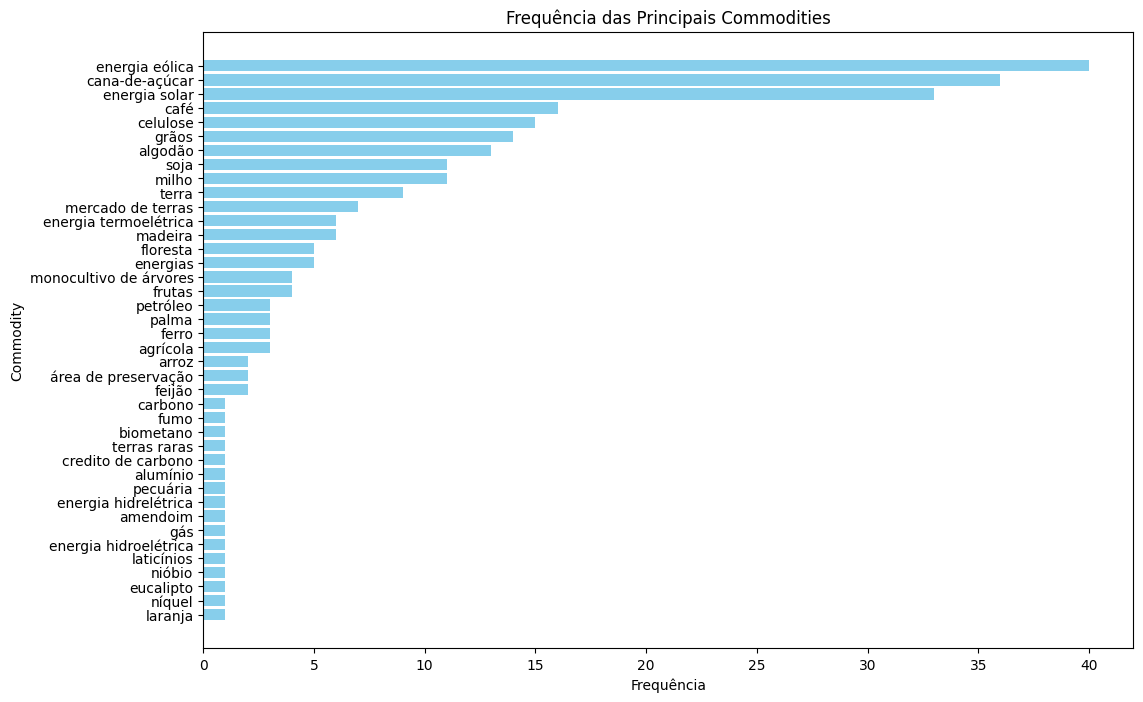

In [ ]:
# Visualização usando um gráfico de barras horizontal
plt.figure(figsize=(12, 8))
plt.barh(commodity_counts['TIPOS-DE-COMMODITIES'], commodity_counts['NUM-COMMODITIES'], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Commodity')
plt.title('Frequência das Principais Commodities')
plt.gca().invert_yaxis()  # Inverter o eixo Y para ter a maior barra no topo
plt.show()

Vemos que aqui a distribuição também está desbalanceada, em que boa parte dos commodities aparece menos que 5 vezes.

Percebemos que as principais commodities são: Energia eólica, Cana-de-açúcar, Energia solar, Café e Celulose.

Seria interessante poder definir os tipos de extrativismos ou a concentração de commoditie por estado. No entanto, pela natureza da tabela, não conseguimos realizar essa consulta.

In [ ]:
print("Descrição Estatística dos Dados:")
print(commodity_counts['NUM-COMMODITIES'].describe())

print("\nMediana:", commodity_counts['NUM-COMMODITIES'].median())

Descrição Estatística dos Dados:
count    40.000000
mean      6.725000
std       9.623655
min       1.000000
25%       1.000000
50%       3.000000
75%       7.500000
max      40.000000
Name: NUM-COMMODITIES, dtype: float64

Mediana: 3.0


Como os dados estão desbalanceados, iremos considerar a mediana para a nossa análise. Assim, enquanto a mediana das commodities é de 3 entradas, o máximo chega a ter 40 entradas.

Podemos observar um boxplot desses dados, para entender melhor a sua distribuição:

<Axes: >

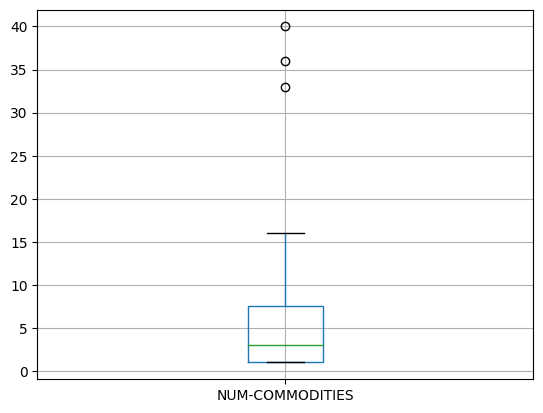

In [ ]:
commodity_counts.boxplot(column=['NUM-COMMODITIES'])

Como revelado pelo boxplot, a diferença entre os valores da média e da mediana se dá em relação a presença de outliers nos dados.

Por fim, iremos ver a relação entre as 5 principais commodities com as demais. Para tanto, iremos considerar as porcentagens das 5 principais commodities em detrimento dos outros valores.

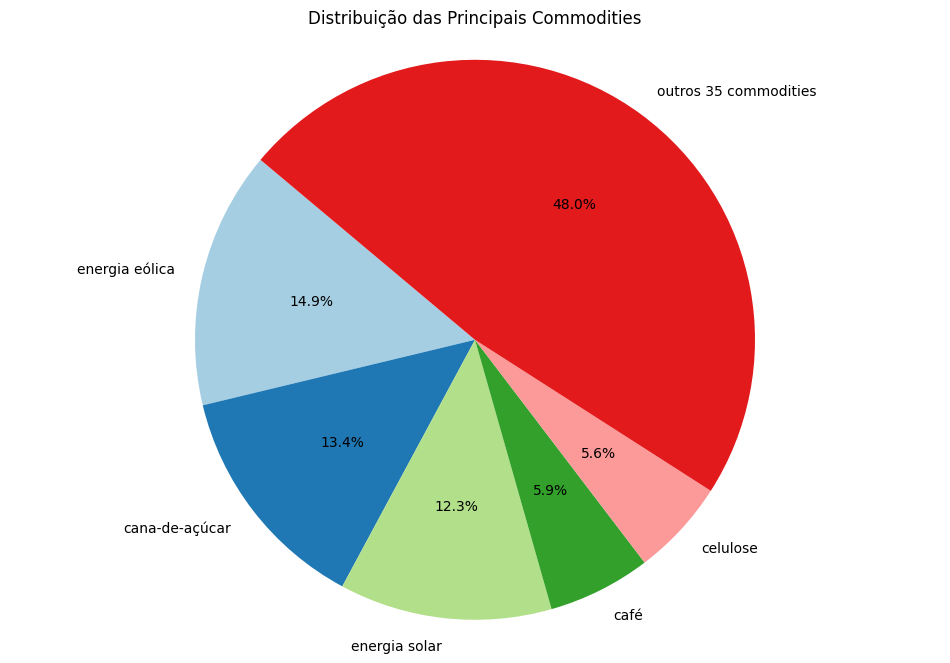

In [ ]:
# Identificar as 5 principais commodities
top_5 = commodity_counts.nlargest(5, 'NUM-COMMODITIES')

# Agrupar as demais commodities em "Outros"
others = pd.DataFrame([[f"outros {len(commodity_counts) - len(top_5)} commodities", commodity_counts['NUM-COMMODITIES'][5:].sum()]], columns=['TIPOS-DE-COMMODITIES', 'NUM-COMMODITIES'])

# Combinar as 5 principais commodities com "Outros"
top_5_with_others = pd.concat([top_5, others])

# Criar o gráfico de pizza
plt.figure(figsize=(12, 8))
plt.pie(top_5_with_others['NUM-COMMODITIES'], labels=top_5_with_others['TIPOS-DE-COMMODITIES'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribuição das Principais Commodities')
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.
plt.show()

Com isso, conseguimos perceber o peso que as 5 principais commodities possuem no dado. Os 5 mais frequentes - um pouco mais que 10% dos dados - ocupam 52% das entradas de commodities no dataset.

## Conclusão

Após o tratamento e análise dos dados, discutimos os seguintes pontos:

* Principais Corporações: Identificamos as principais corporações na aquisição de terras no Brasil e percebemos uma distribuição heterogênea dessas empresas.
* Origem do Capital: Constatamos que o capital vem principalmente dos Estados Unidos da América, além de uma presença significativa de capital estrangeiro por meio de empresas brasileiras.
* Regiões e Estados: Observamos a preferência por estados vizinhos ao centro do país, com uma clara centralização no eixo Bahia, São Paulo e Minas Gerais.
* Principais Commodities: Identificamos a preferência por determinadas commodities, como energia eólica, cana-de-açúcar e energia solar.

Essa análise auxilia na compreensão dos fins para os quais o capital estrangeiro está utilizando terras brasileiras, bem como onde está majoritariamente presente. No entanto, a análise pode não refletir a dimensão real dessas aquisições, pois não são apontadas a extensão de área ocupada por cada corporação e commodity. Além disso, devido à presença de múltiplos valores em diferentes colunas, não foi possível cruzar todos os dados.

Portanto, destacamos a necessidade de refinamento nos dados para permitir futuras análises mais complexas e confiáveis.

# Cruzamento das tabelas

Estamos interessados em saber se existe alguma relação entre o número de assentamentos em um estado e a frequência de estrangerização de terra nesses estados.

In [ ]:
# Pega contagem de frequência de estados da tabela de estrangerização.
estrang_state_counts = state_counts.drop(columns=['REGIÃO']).rename(columns={'NUM-UF': 'ESTRANG-NUM-UF'})
estrang_state_counts.head()

,UF,ESTRANG-NUM-UF
0,BA,56
1,SP,54
2,MG,50
3,MS,31
4,GO,31


In [ ]:
# Contar o número de ocorrências de cada UF na tabela de assentamentos
assent_uf_counts = assent_data_back_cat['UF'].value_counts().reset_index()
assent_uf_counts.columns = ['UF', 'ASSENT-NUM-UF']

assent_uf_counts.head()

,UF,ASSENT-NUM-UF
0,MA,924
1,PA,848
2,BA,690
3,PE,568
4,PI,465


In [ ]:
# Criar dataframe com a contagem das duas tabelas para os estados
state_counts = estrang_state_counts.merge(assent_uf_counts, on='UF', how='left')

state_counts.head()

,UF,ESTRANG-NUM-UF,ASSENT-NUM-UF
0,BA,56,690
1,SP,54,226
2,MG,50,371
3,MS,31,178
4,GO,31,444


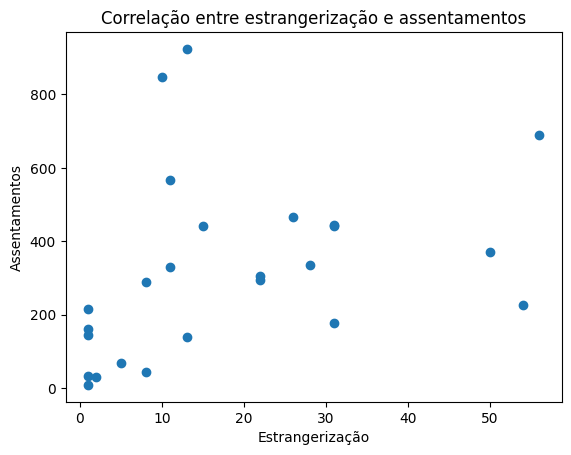

In [ ]:
correlation = state_counts[['ESTRANG-NUM-UF', 'ASSENT-NUM-UF']].corr()

plt.scatter(state_counts['ESTRANG-NUM-UF'], state_counts['ASSENT-NUM-UF'])
plt.xlabel('Estrangerização')
plt.ylabel('Assentamentos')
plt.title('Correlação entre estrangerização e assentamentos')
plt.show()

In [ ]:
correlation_value = correlation.iloc[0, 1]
print(f'Coeficiente de correlação: {correlation_value}')

Coeficiente de correlação: 0.3530536436367158


Aparentemente não há uma correlação entre o número de estranheirizações e o número de assentamos. Como podemos observar, os dados estão bastante dispersos e não representam nem uma correlação positiva e nem uma correlação negativa. Além disso, o coeficiente de correlação é de 0.35.